In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.io import fits
from scipy.signal import argrelextrema
from scipy.optimize import differential_evolution, curve_fit
from scipy.stats import linregress
from numpy import polyfit
from astropy.modeling import models, fitting

In [2]:
#all the fits files for the same star
fits_filenames = [
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q1.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q2.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q3.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q4.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q5.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q6.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q7.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q8.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q9.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q10.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q11.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q12.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q13.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q14.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q15.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q16.fits',
                  '/home/donlon/Desktop/data/kepler_data/nr_lyrae/q17.fits',
                 ]

#load in all the data and build the dictionaries
data = {}
for i, f in enumerate(fits_filenames):
    
    hdul = fits.open(f)
    
    # Read in the "BJDREF" which is the time offset of the time array.
    bjdrefi = hdul[1].header['BJDREFI'] 
    bjdreff = hdul[1].header['BJDREFF']

    # Read in the columns of data.
    times = hdul[1].data['time'] 
    sap_fluxes = hdul[1].data['SAP_FLUX']
    pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX']

    bjds = times + bjdrefi + bjdreff 

    sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
    sample_rate = 1/sample_spacing
    
    data[i] = {
               'bjds': bjds,
               'sap_fluxes': sap_fluxes,
               'pdcsap_fluxes': pdcsap_fluxes,
               'sample_spacing': sample_spacing,
               'sample_rate': sample_rate
              }
    
print('data read in successfully')


data read in successfully


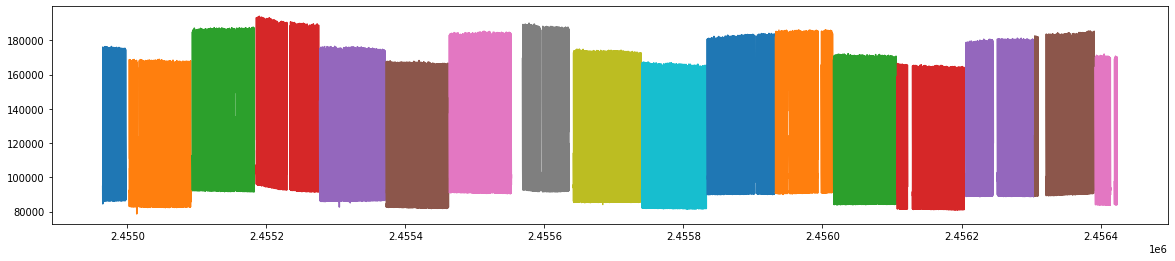

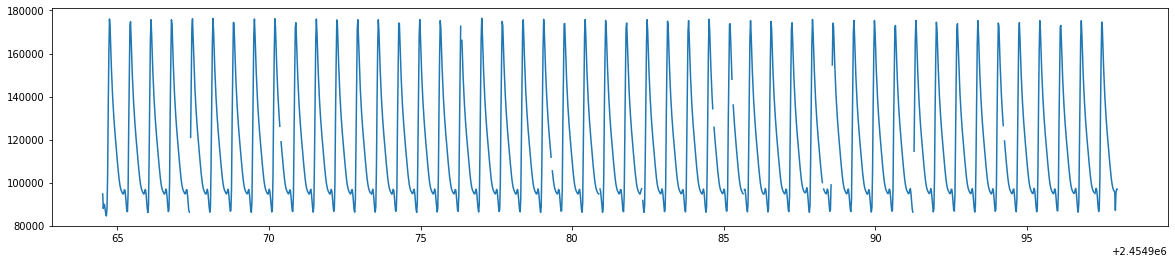

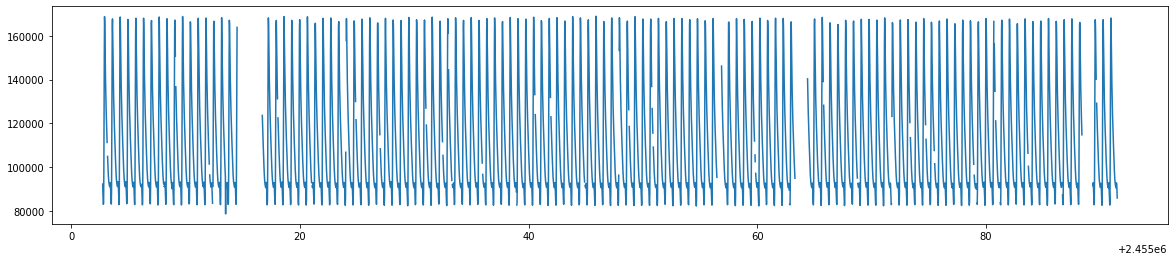

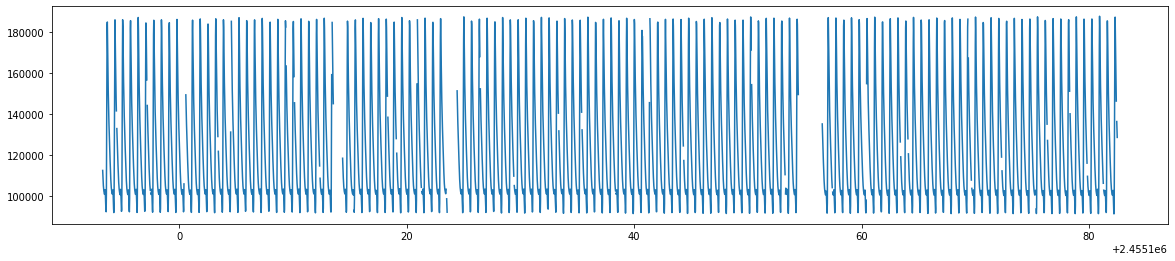

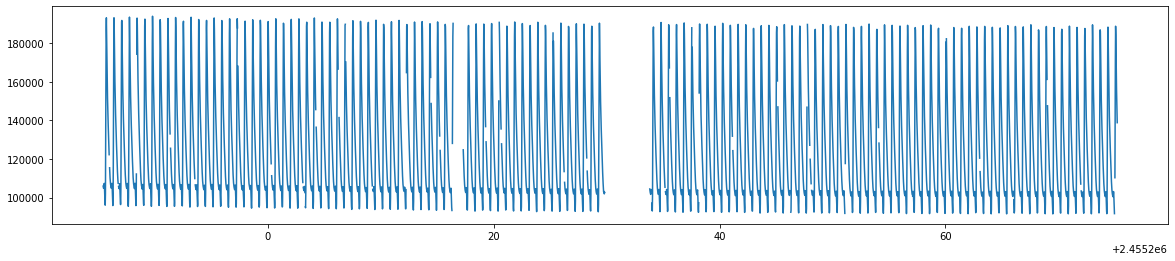

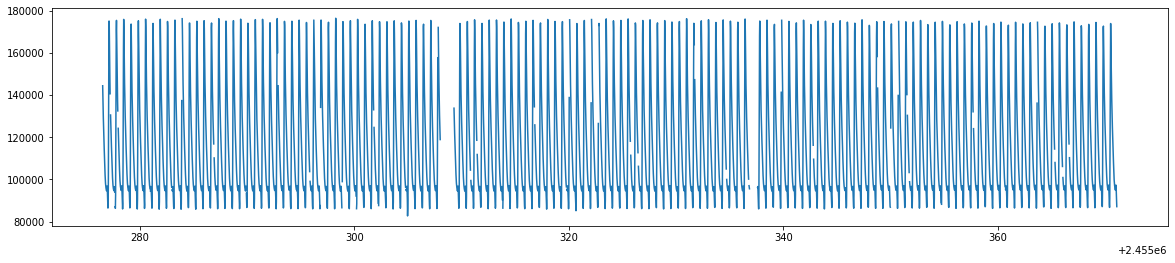

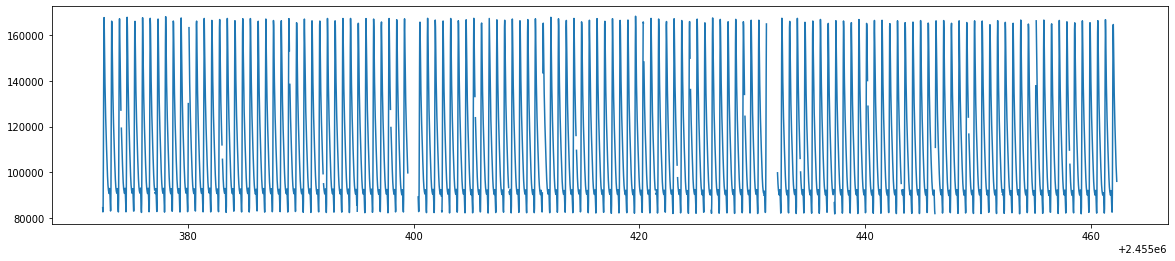

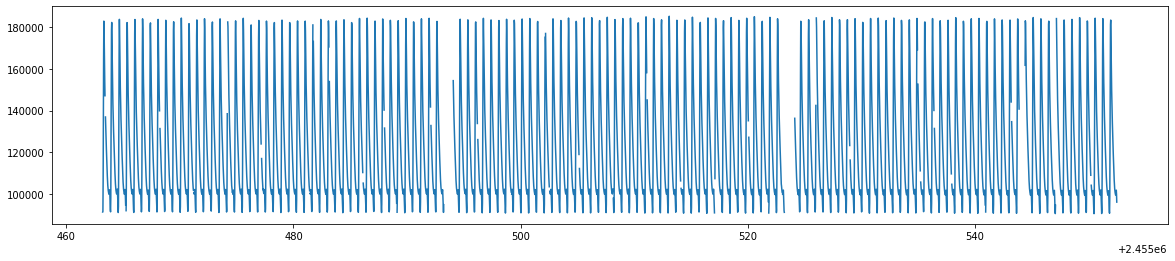

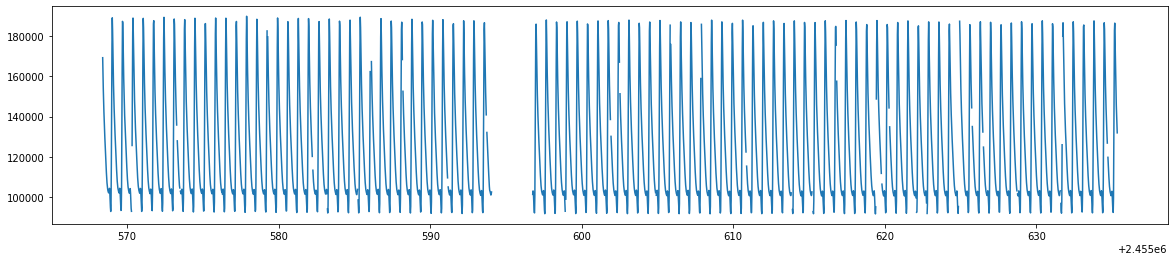

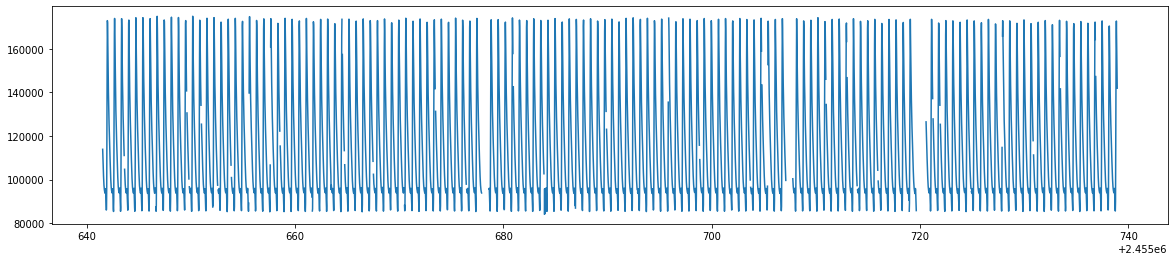

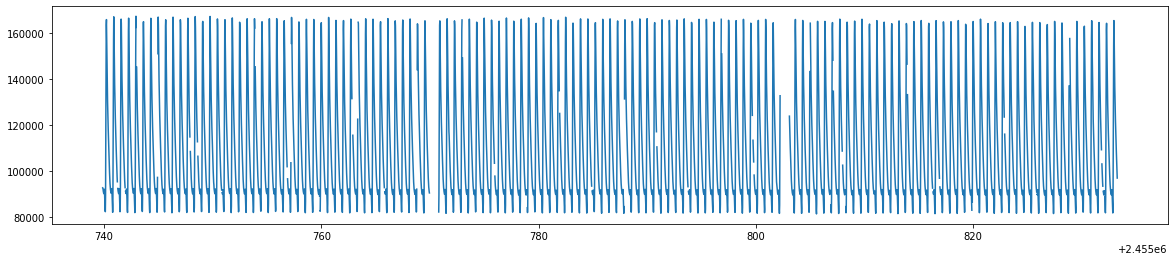

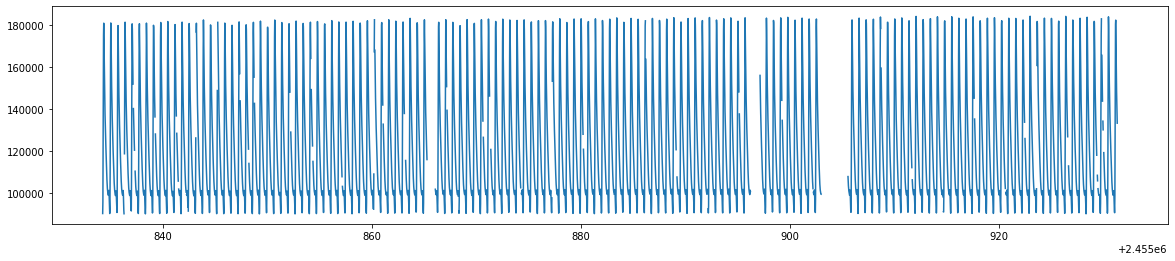

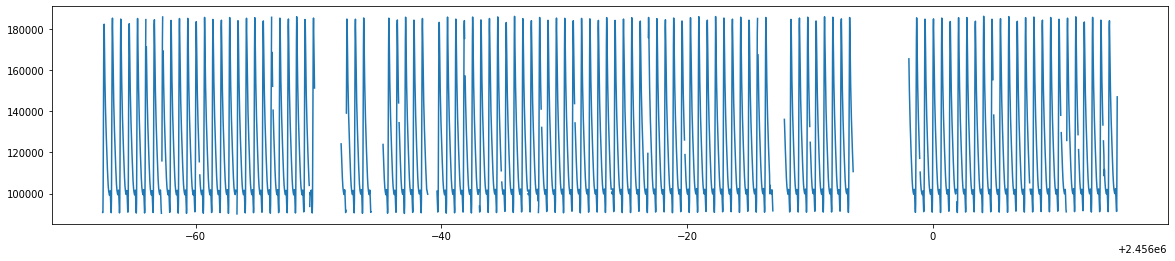

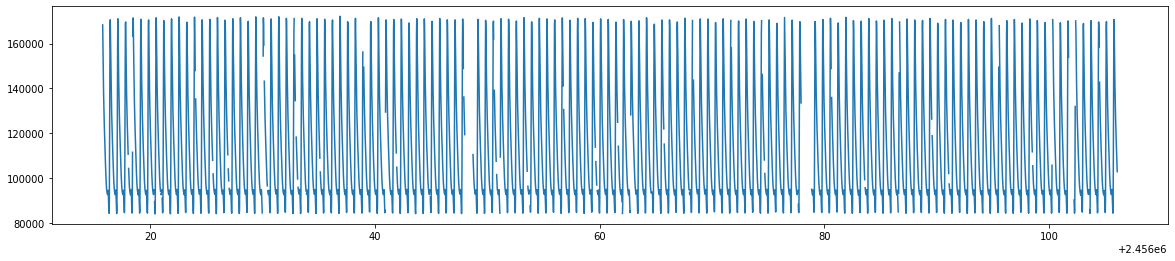

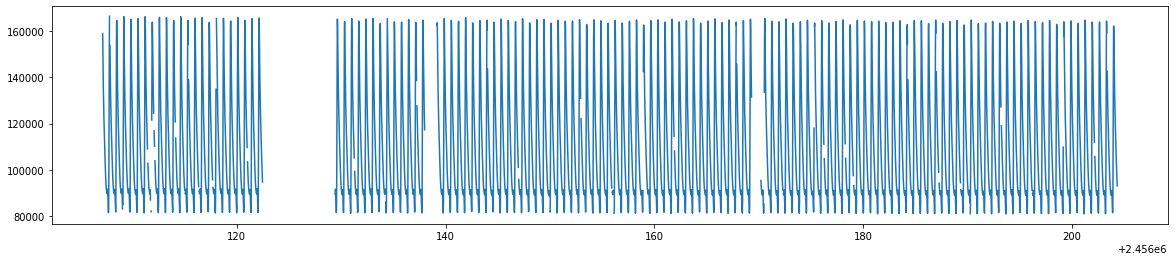

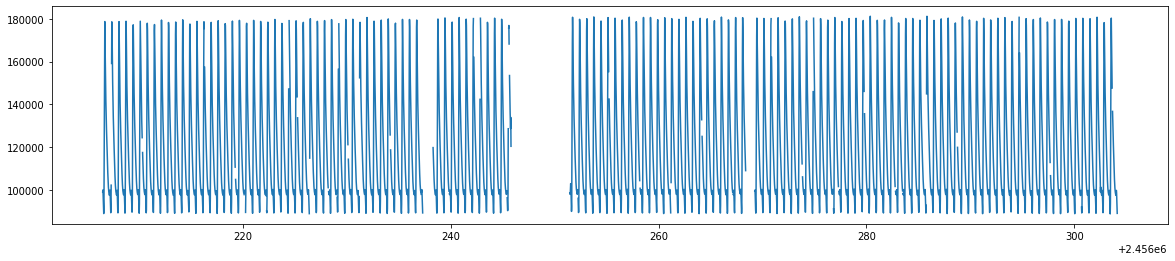

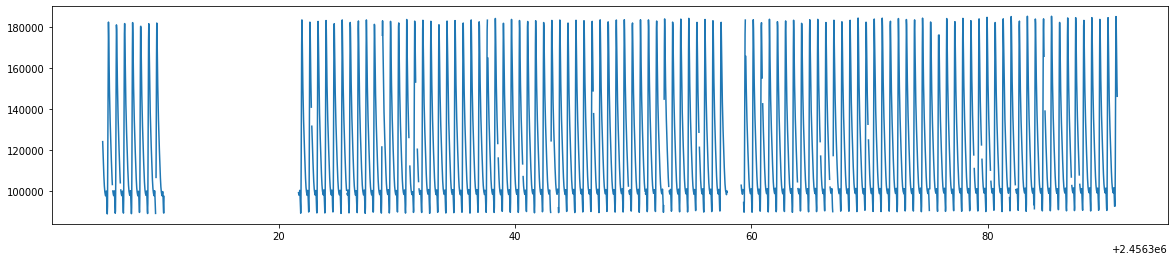

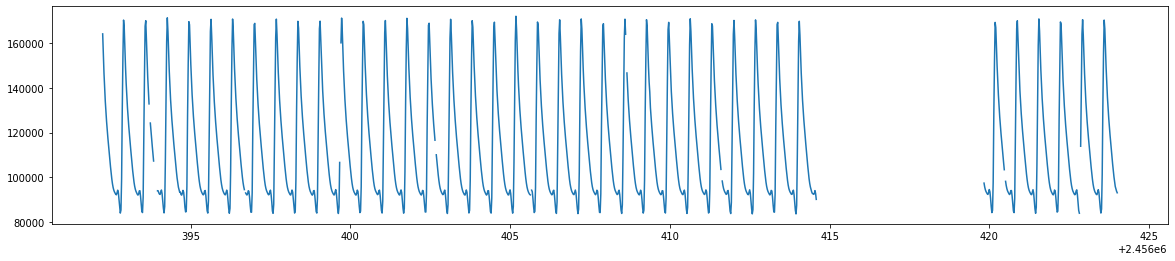

In [3]:
#make some plots of the data

#all the data
fig = plt.figure(figsize=(20, 4))
for key in data.keys():
    plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
plt.show()

#each time slice
for key in data.keys():
    fig = plt.figure(figsize=(20, 4))
    plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
    plt.show()

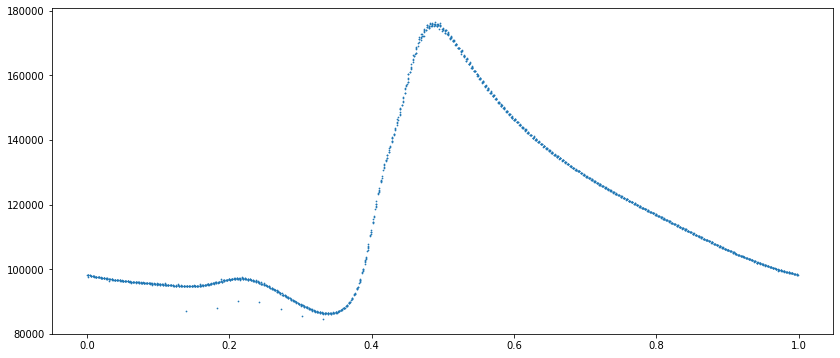

/tmp/ipykernel_2988/3282634693.py:5: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % period)/period


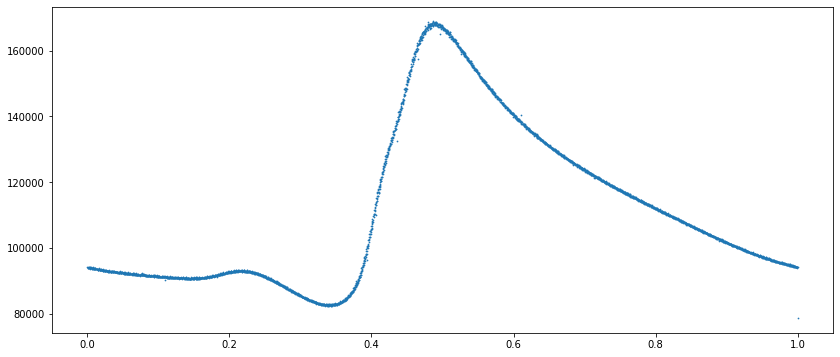

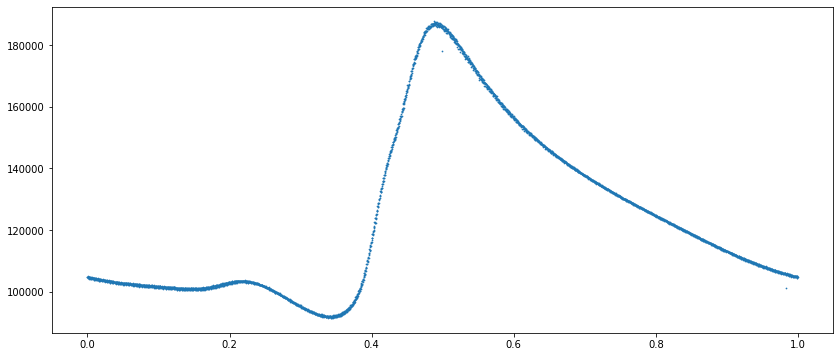

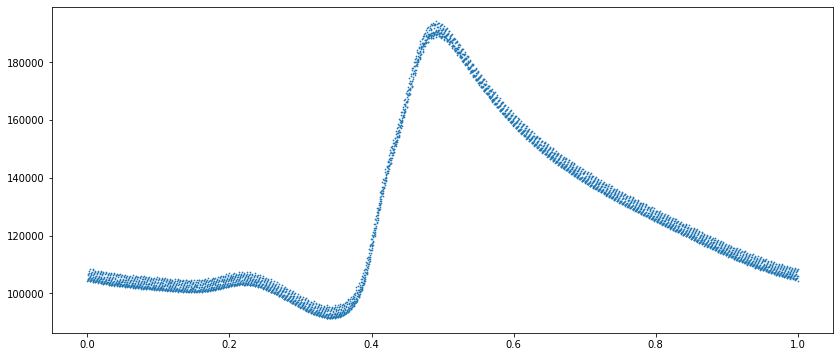

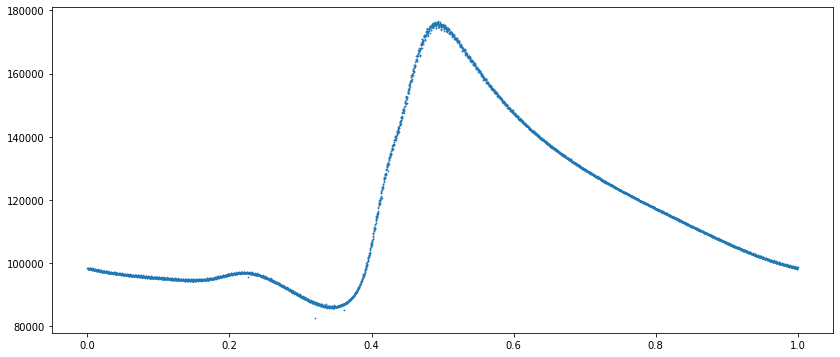

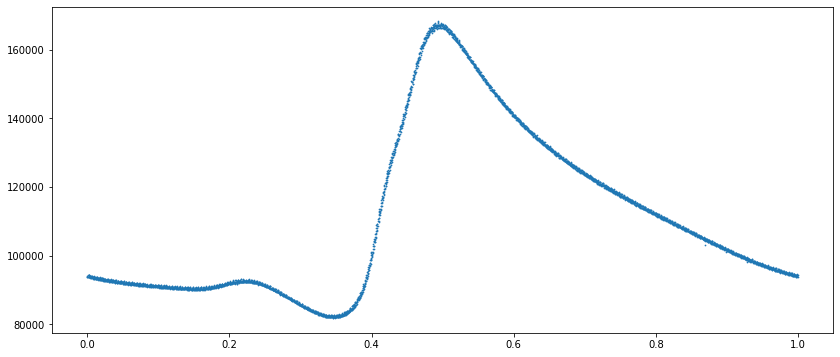

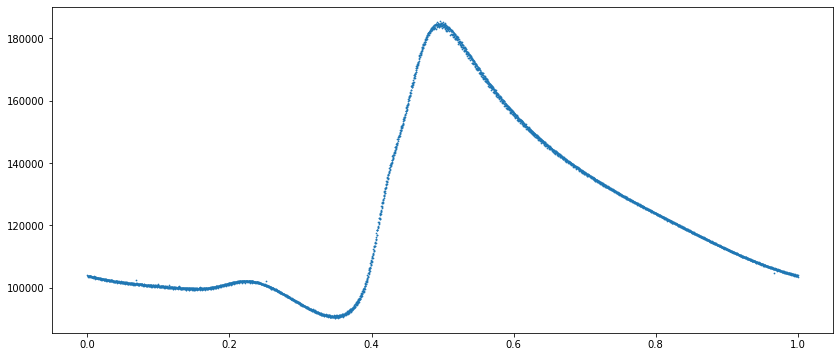

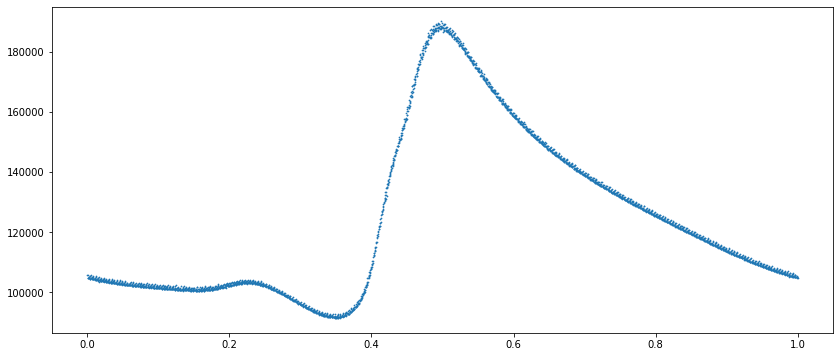

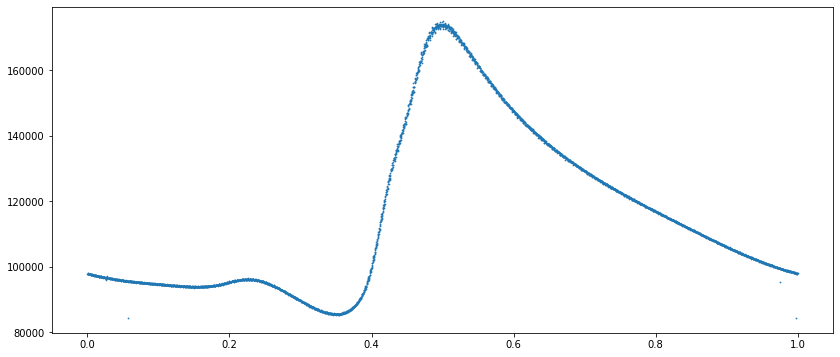

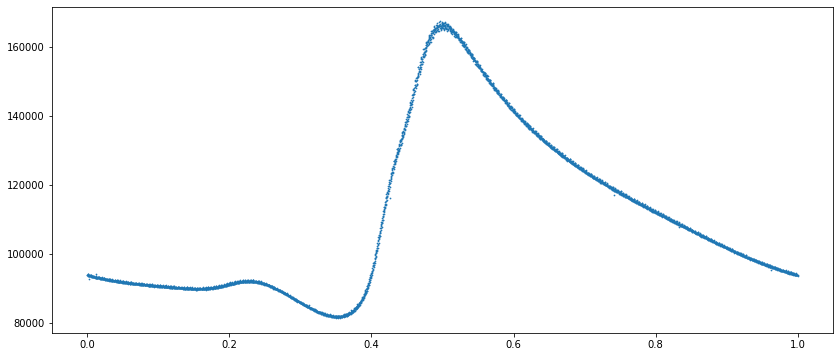

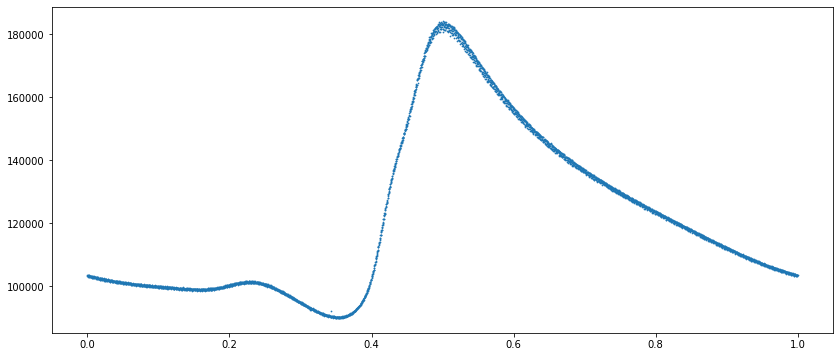

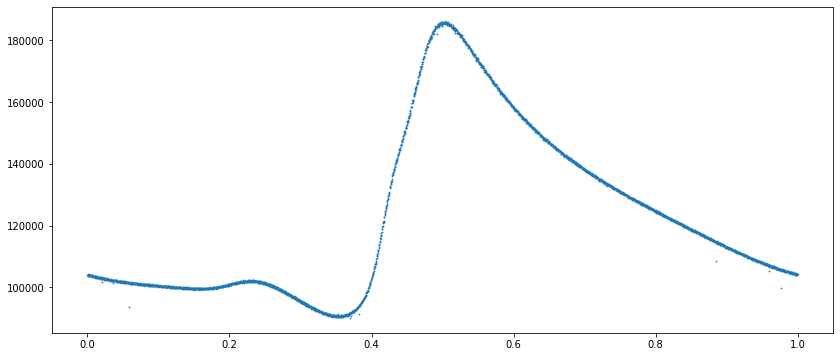

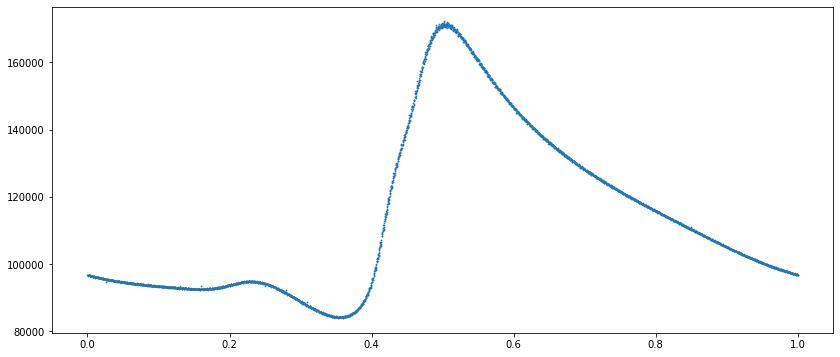

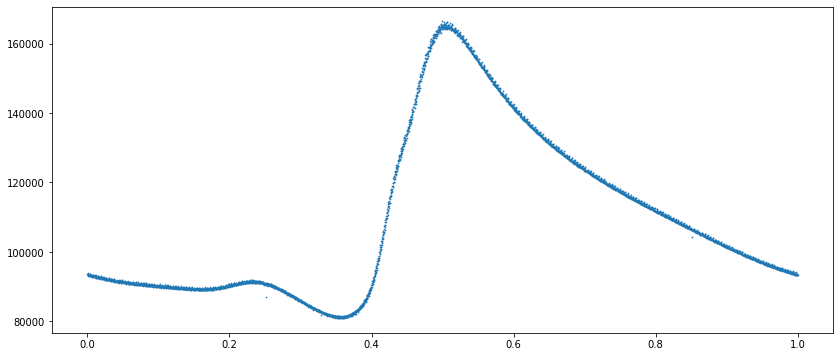

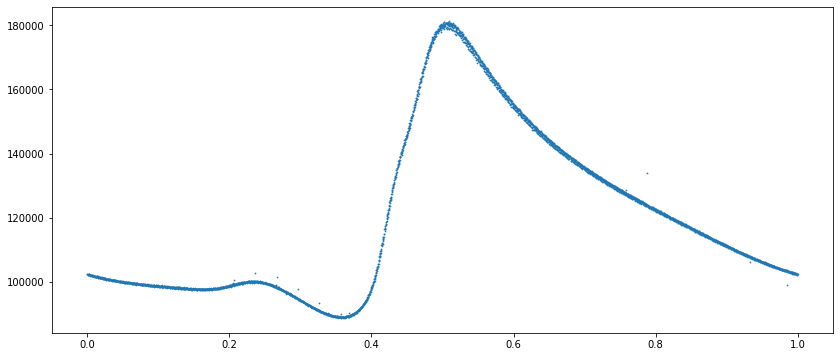

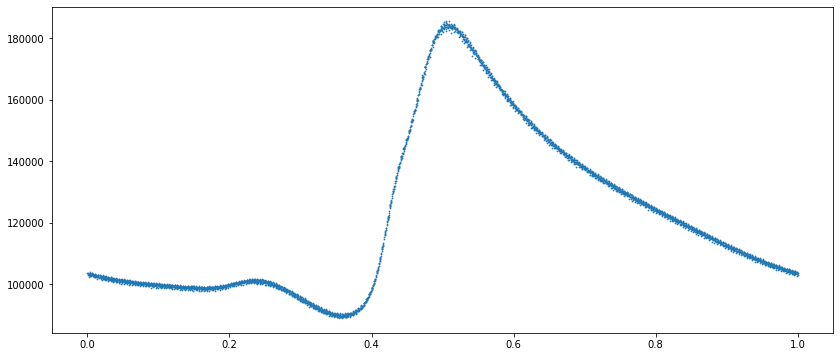

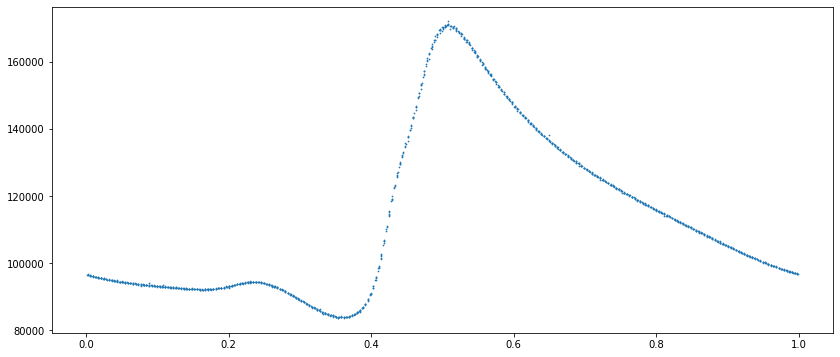

In [4]:
#plot folded data 
period = 0.68202 #BJDs, technically a period guess

for key in data.keys():
    folded_bjds = (data[key]['bjds'] % period)/period

    fig = plt.figure(figsize=(14, 6))
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=0.5)
    plt.show()

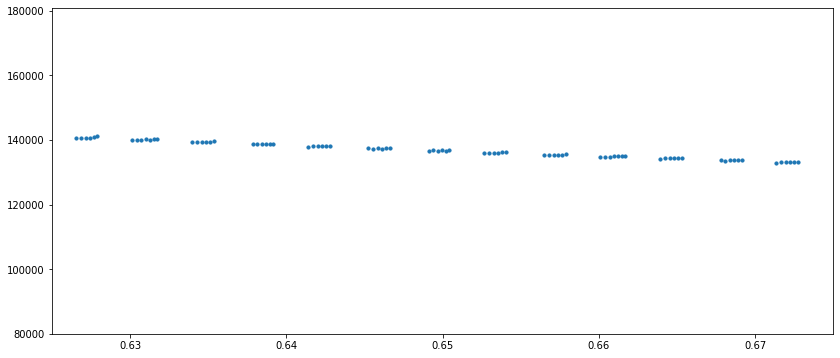

/tmp/ipykernel_2988/1671066977.py:2: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % period)/period


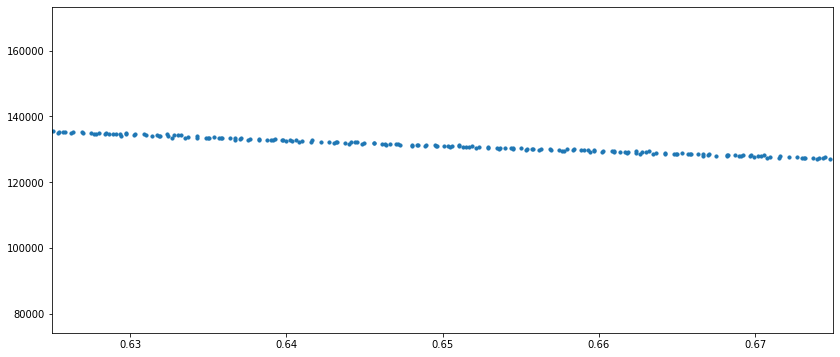

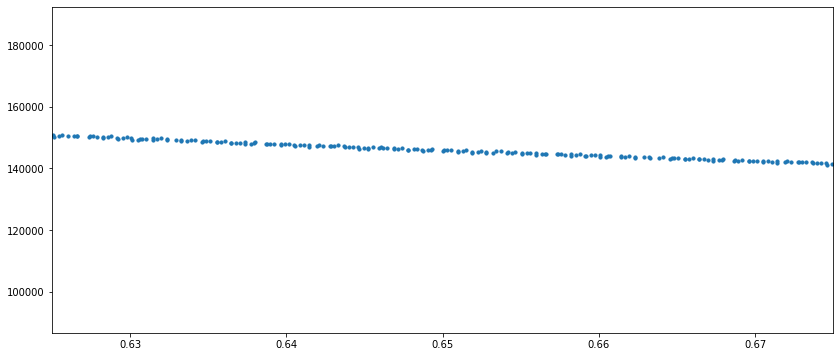

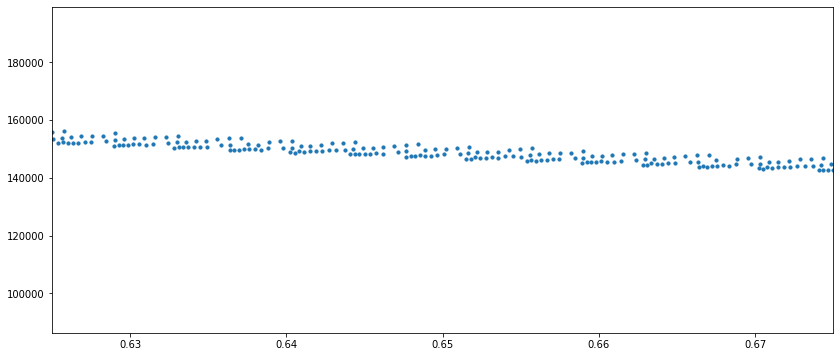

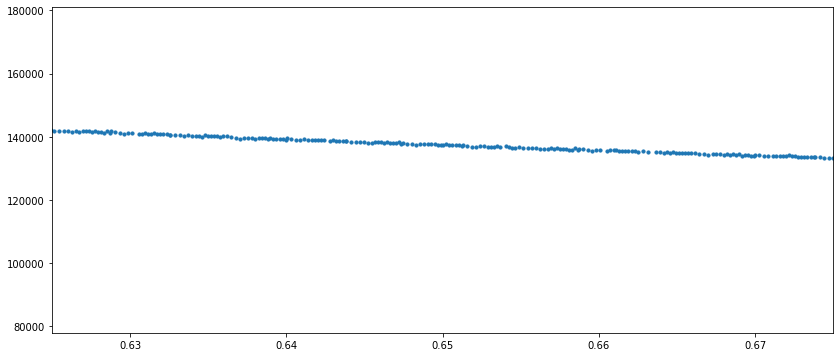

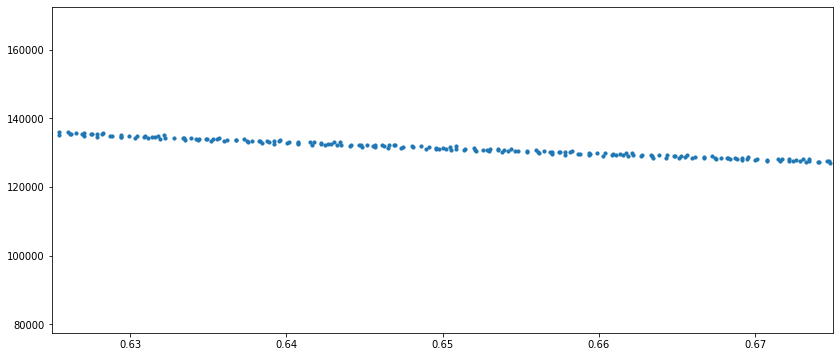

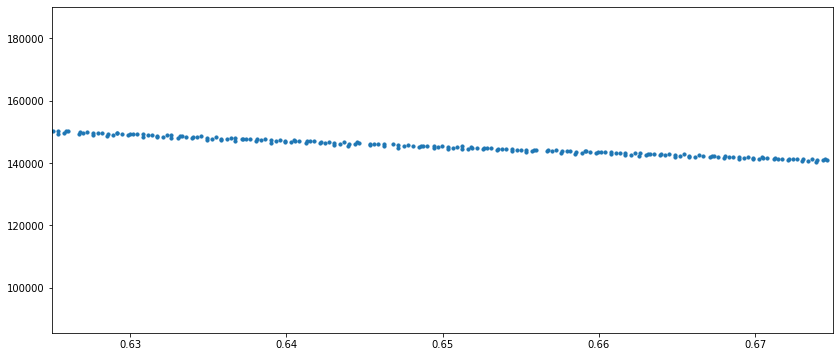

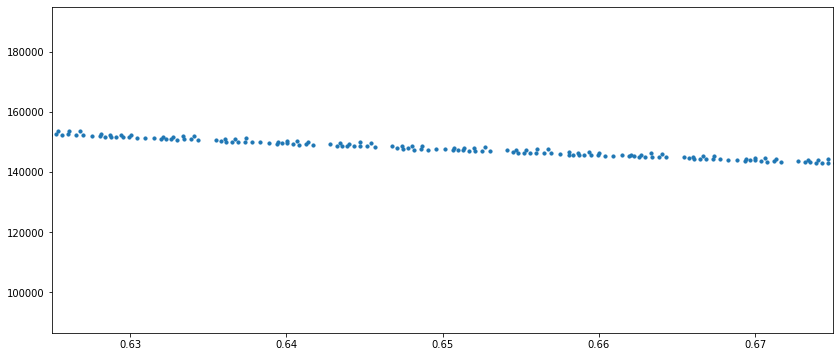

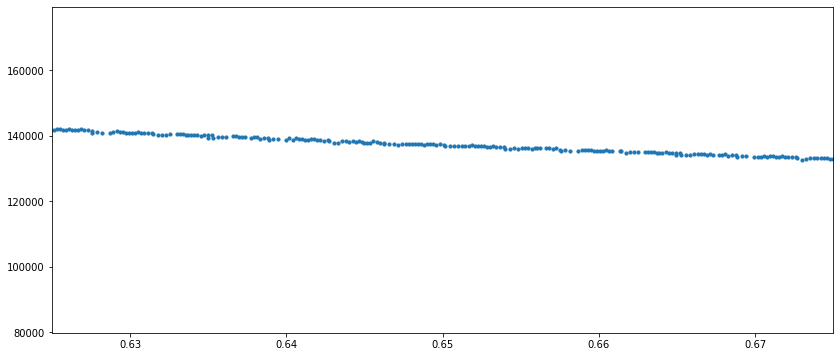

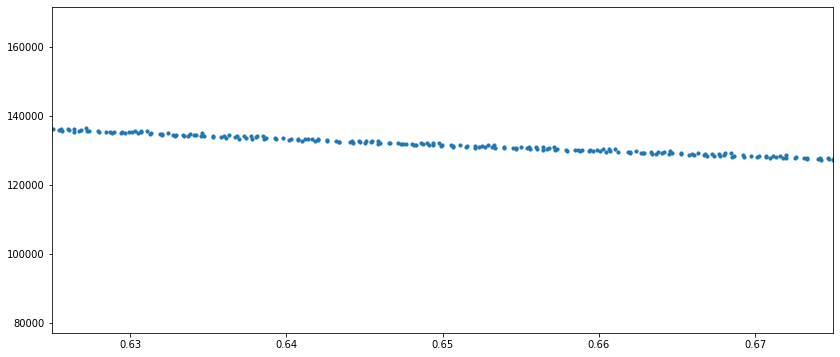

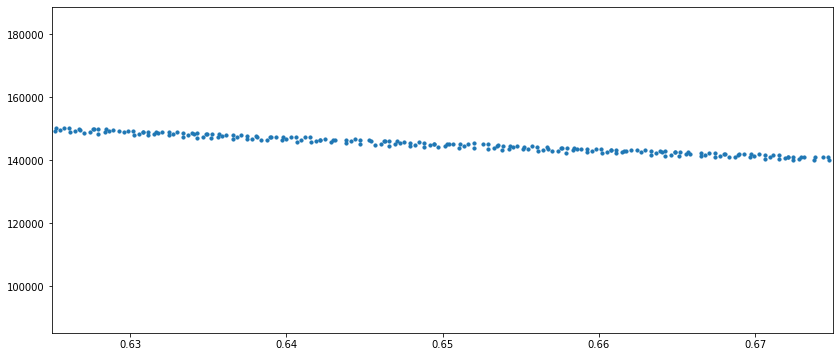

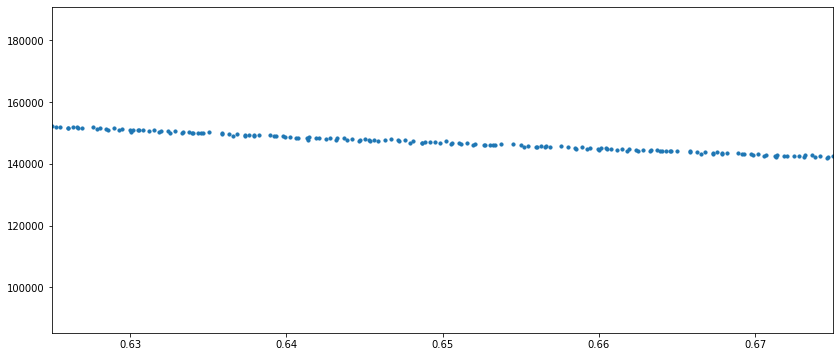

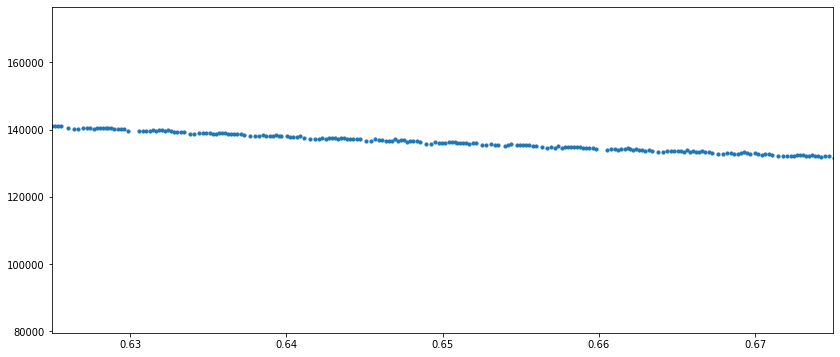

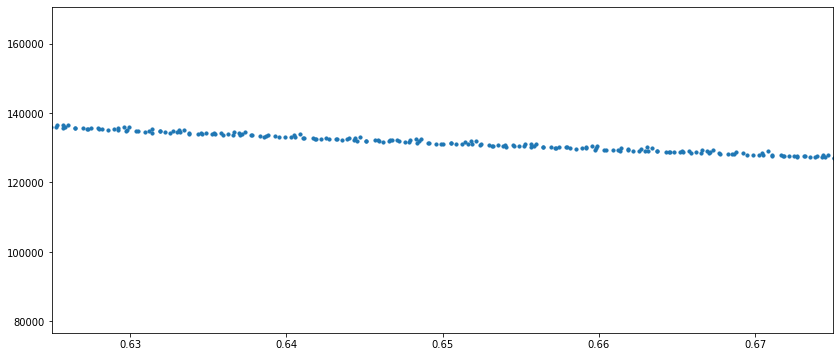

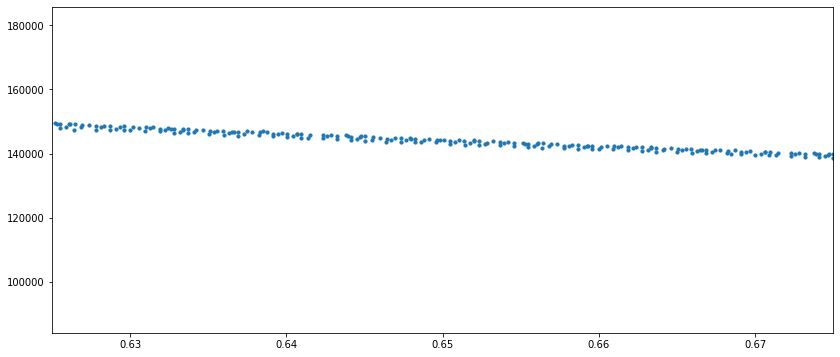

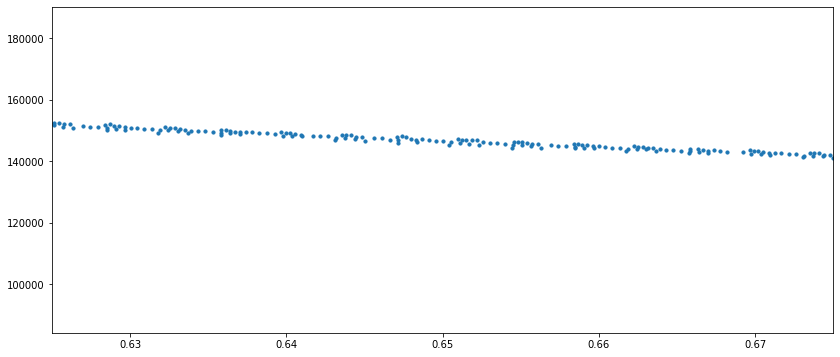

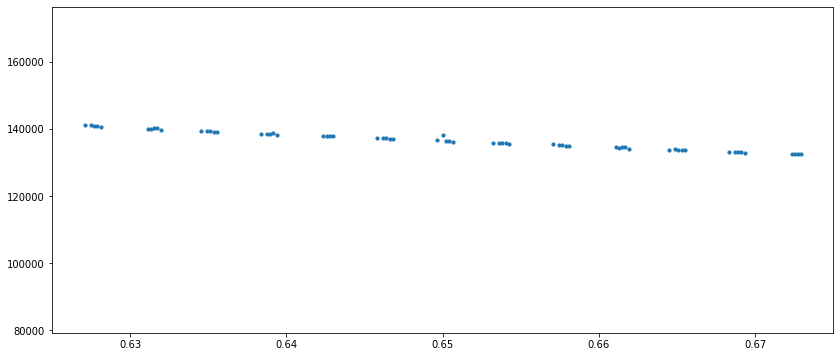

In [5]:
for key in data.keys():
    folded_bjds = (data[key]['bjds'] % period)/period

    fig = plt.figure(figsize=(14, 6))
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10)
    plt.xlim(0.625, 0.675)
    plt.show()

In [6]:
#the optimizer
def likelihood(period, data, verbose_out=False):
   
    #fold the data based on the period
    folded_bjds = (data['bjds'] % period)/period
    
    #bin the data (try 0.01 period bins)
    bin_width = 0.005
    binned_pdcsap_fluxes = []
    binned_bjds = []
    
    i = 0
    while i < 1:
        indx = (folded_bjds >= i)*(folded_bjds < i+bin_width)
        binned_pdcsap_fluxes.append(data['pdcsap_fluxes'][indx])
        binned_bjds.append(folded_bjds[indx])
        i += bin_width
        
    #i hate this
    binned_pdcsap_fluxes = np.array(binned_pdcsap_fluxes)
    binned_bjds = np.array(binned_bjds)
    
    #compute the dispersion of each bin w.r.t. a linear fit:    
    #then adjust the data according to that linear fit
    slope_adj_fluxes = []
    lfs = []
    for i in range(len(binned_bjds)):
        indx = (np.logical_not(np.isnan(binned_bjds[i])))*(np.logical_not(np.isnan(binned_pdcsap_fluxes[i])))
        lf = linregress(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
        lfs.append(lf)
        slope_adj_fluxes.append([binned_pdcsap_fluxes[i][indx][j] - (lf[0]*binned_bjds[i][indx][j] + lf[1]) for j in range(len(binned_pdcsap_fluxes[i][indx]))])
    
        #these are to plot the linear fits if we think there's a problem with those
        #fig = plt.figure(figsize=(6, 6))
        #plt.scatter(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
        #plt.plot([np.min(binned_bjds[i][indx]), np.max(binned_bjds[i][indx])], [lf[0]*np.min(binned_bjds[i][indx]) + lf[1], lf[0]*np.max(binned_bjds[i][indx]) + lf[1]], c='k', ls='--')
        #plt.show()
    
    disps = np.array([np.nanstd(f) for f in slope_adj_fluxes])
    for i in range(len(disps)):
        if len(binned_pdcsap_fluxes[i]) == 0:
            disps[i] = np.nan
    
    #likelihood score is just the sum of all dispersions
    penalty = 1000 #penalize not having anything in a bin
    like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty
    
    if verbose_out:
        return like, disps, lfs
    else:
        return like

def optimize_time_slices(data):
    
    best_periods = []
    
    for key in data.keys():
        result = minimize(likelihood, period, args=data[key], bounds=[[0, 2]])
        best_periods.append(result.x)
        
    return best_periods

def optimize_time_slices_de(data):
    
    #differential evolution controls
    pop_size = 10 #10 times number of parameters
    diff_scaling_factor = 0.8
    crossover_rate = 0.9
    max_it = int(1e10)
    
    best_periods = []
    
    for key in data.keys():
        result = differential_evolution(likelihood, 
                                        [(period*0.95, period*1.05)], #bounds
                                        args=(data[key],), 
                                        maxiter=max_it, 
                                        popsize=pop_size, 
                                        mutation=diff_scaling_factor, 
                                        recombination=crossover_rate, 
                                        workers=-1, 
                                        disp=False)
        best_periods.append(result.x)
        
    return best_periods

#brute force bc I think that the likliehood surface isn't actually differentiable
def scan_time_slices(data):
    
    scan_width = 0.0000005
    scan_n = 1e2
    times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)
    
    best_periods = []
    all_like_list = []
    
    for key in data.keys():
        
        all_likes = []
    
        best_period = period
        best_like = likelihood(period, data[key])

        for p in times:
            like = likelihood(p, data[key])
            all_likes.append(like)
            if like < best_like:
                best_period = p
                best_like = like

        best_periods.append(best_period)
        all_like_list.append(all_likes)
        
    return best_periods, all_like_list, times

In [7]:
#optimize the period of each time slice
#best_periods = optimize_time_slices(data)
#best_periods = optimize_time_slices_de(data)
best_periods, all_like_list, times = scan_time_slices(data)
print('Optimized periods:', best_periods)

/tmp/ipykernel_2988/799681962.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  binned_pdcsap_fluxes = np.array(binned_pdcsap_fluxes)
/tmp/ipykernel_2988/799681962.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  binned_bjds = np.array(binned_bjds)
/tmp/ipykernel_2988/799681962.py:5: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data['bjds'] % period)/period


Optimized periods: [0.6820234999999956, 0.6820269999999953, 0.6820284999999952, 0.6820244999999955, 0.6820254999999954, 0.6820284999999952, 0.6820284999999952, 0.6820224999999956, 0.6820239999999955, 0.6820279999999952, 0.6820249999999954, 0.6820234999999956, 0.6820269999999953, 0.6820269999999953, 0.6820284999999952, 0.6820274999999952, 0.682030999999995]


period: 0.6820128923121501
variance: 7.643431547320043e-09


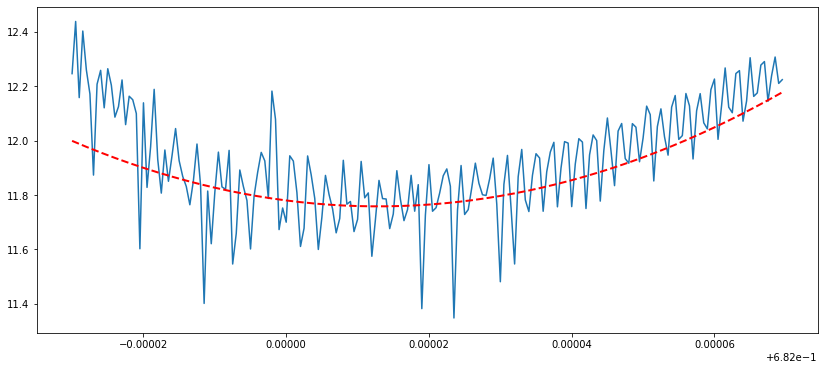

period: 0.6820286187292395
variance: 5.989515563289105e-10


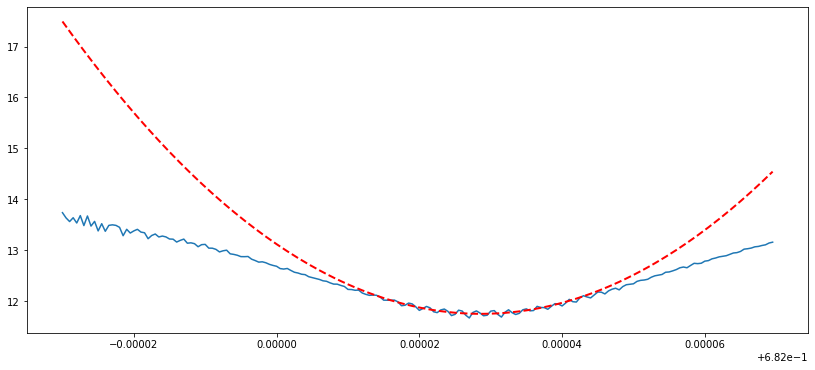

period: 0.682028078391272
variance: 2.6975382961218007e-10


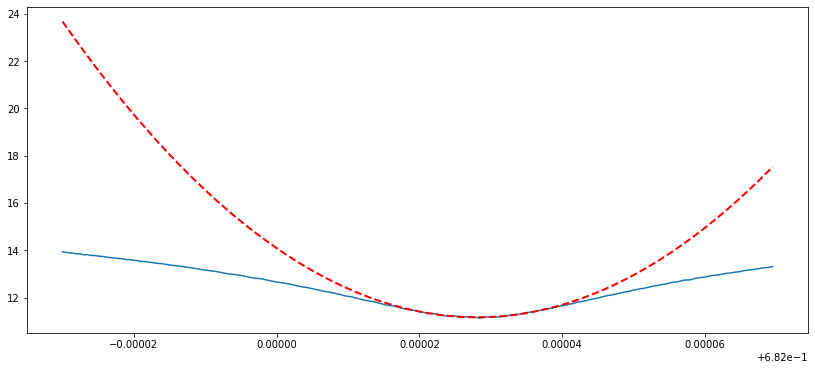

period: 0.6820232029122093
variance: 7.073078875735292e-09


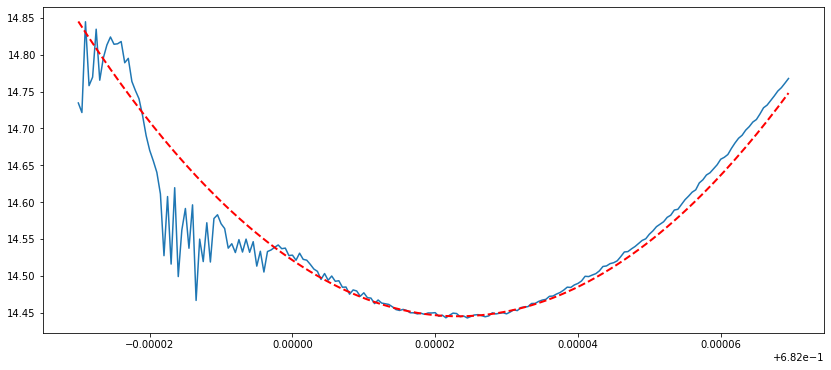

period: 0.6820268307865233
variance: 2.3685880307619653e-10


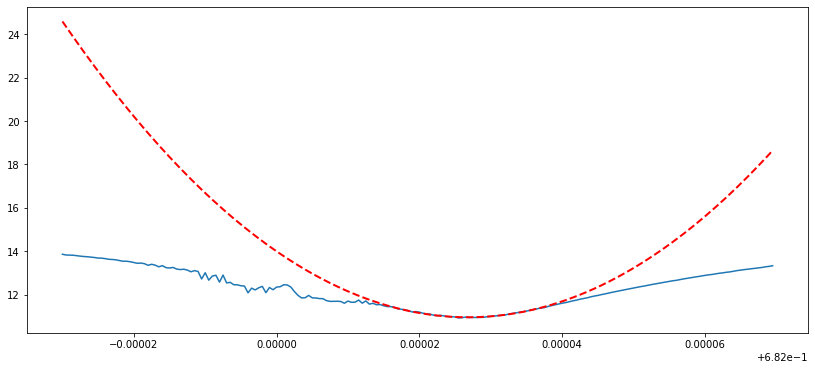

period: 0.6820278693841196
variance: 4.834887747448936e-10


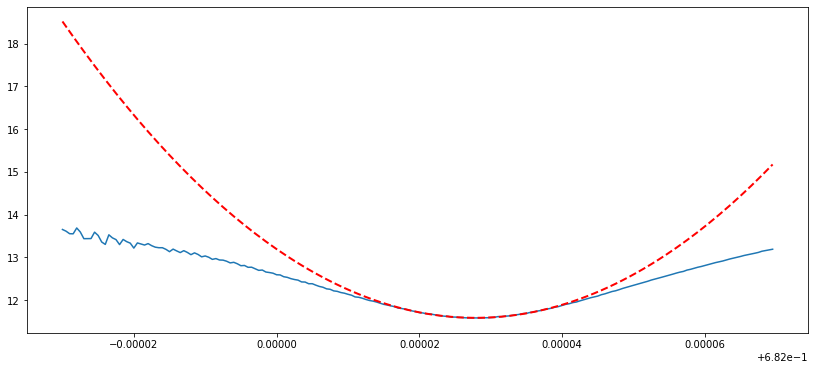

period: 0.6820291417491846
variance: 2.136933091698561e-10


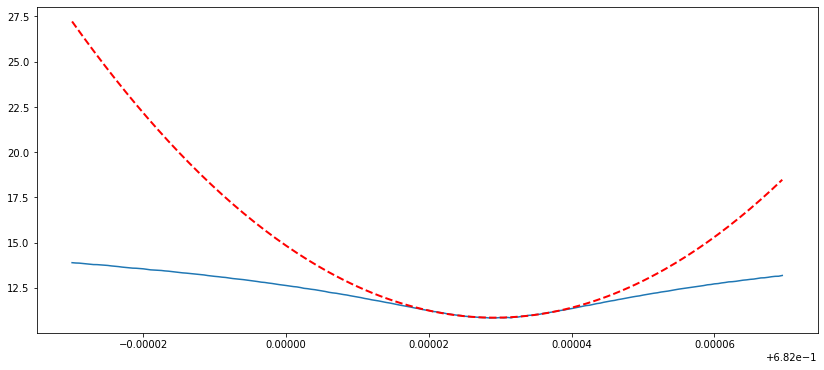

period: 0.6820239189096556
variance: 1.2110479026589438e-09


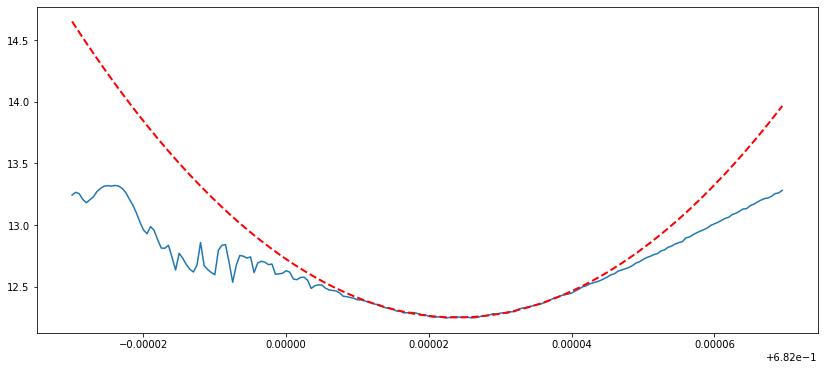

period: 0.682026329100756
variance: 4.518951864133325e-10


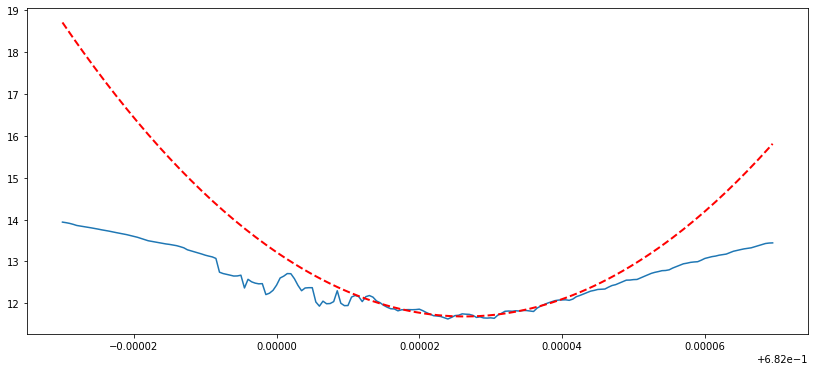

period: 0.6820285463593857
variance: 4.139838812892787e-10


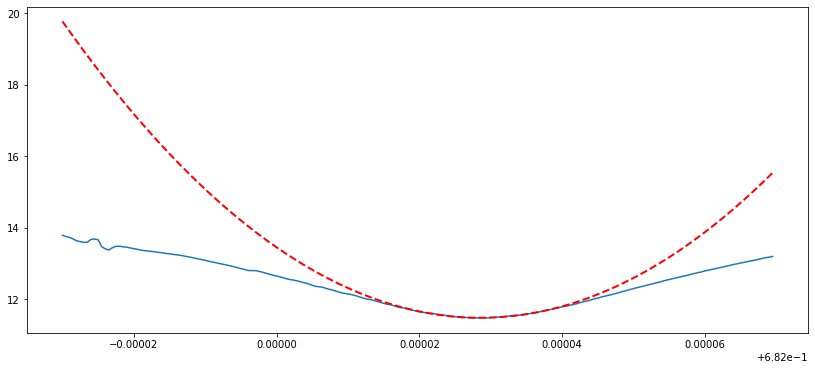

period: 0.6820252156045055
variance: 4.588031636511853e-10


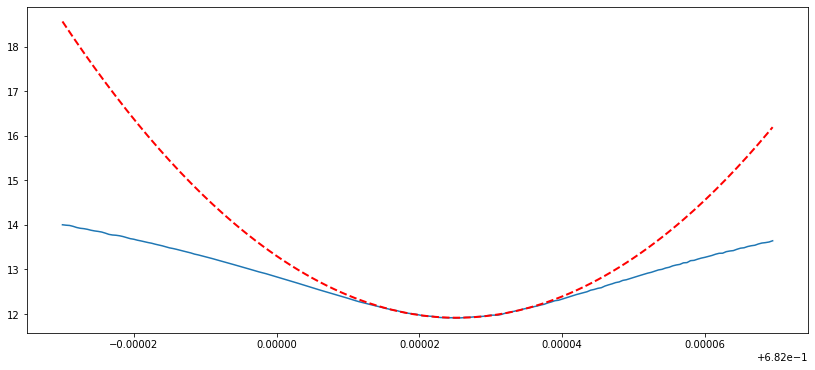

period: 0.6820240727134208
variance: 3.5089634176774714e-10


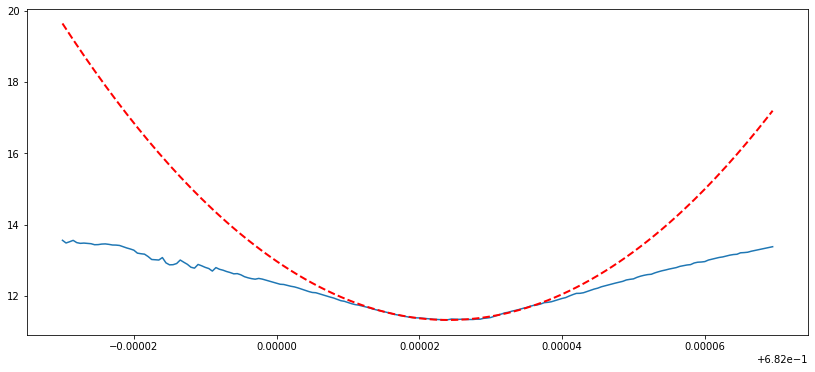

period: 0.6820273521519998
variance: 1.9559676156390103e-10


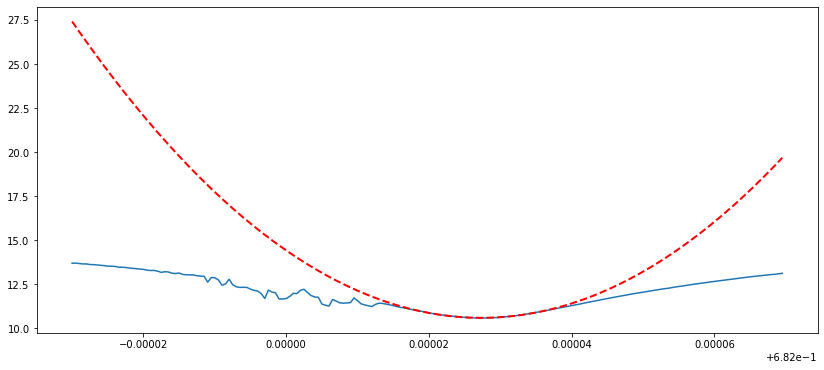

period: 0.682027075105208
variance: 4.090296100023026e-10


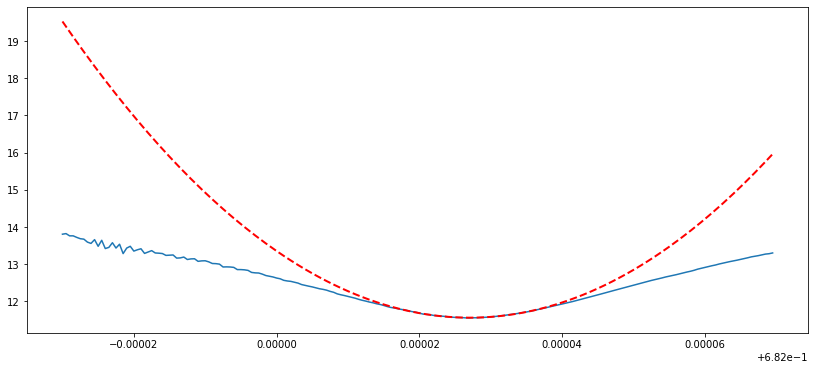

period: 0.6820274506341288
variance: 3.695301957832977e-10


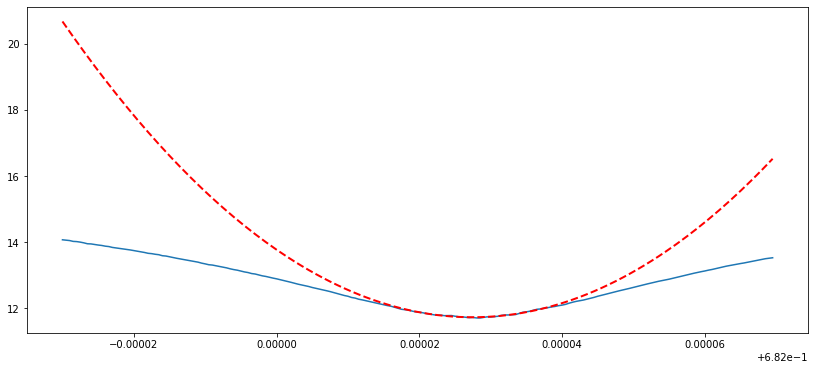

period: 0.682025383733426
variance: 9.360449067748374e-10


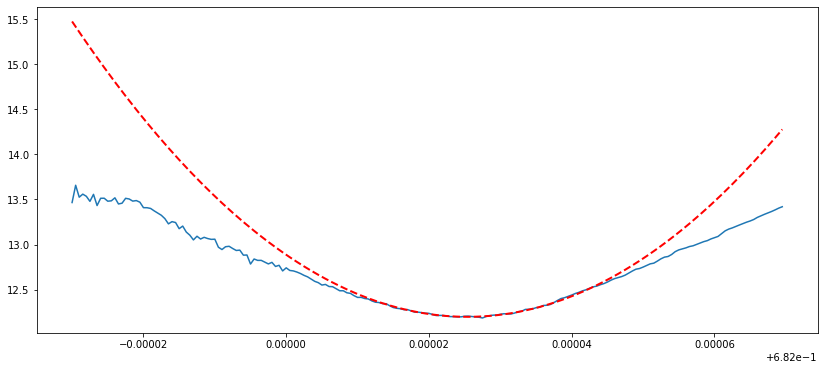

period: 0.6820305985929243
variance: 1.292143123221106e-09


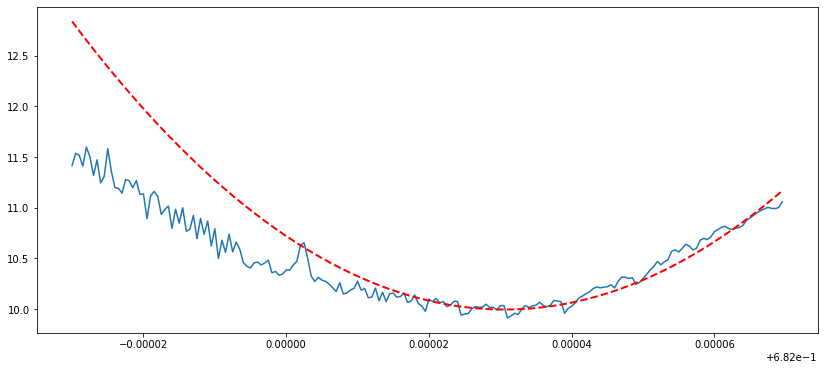

In [8]:
#plot likelihood surfaces
fit_periods = []
variances = []

for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    plt.plot(times, np.log(all_like_list[key]))

    min_indx = np.argmin(all_like_list[key])
    indx = (np.abs(times - times[min_indx]) < 0.00001)
    pf = polyfit(np.array(times)[indx], np.log(np.array(all_like_list)[key][indx]), 2)
    plt.plot(times, pf[0]*times**2 + pf[1]*times + pf[2], c='r', lw=2, ls='--')
    
    fit_period = -pf[1]/(2*pf[0])
    variance = 1/pf[0]
    
    fit_periods.append(fit_period)
    variances.append(variance)
    
    print('period:', fit_period)
    print('variance:', variance)
    
    plt.show()

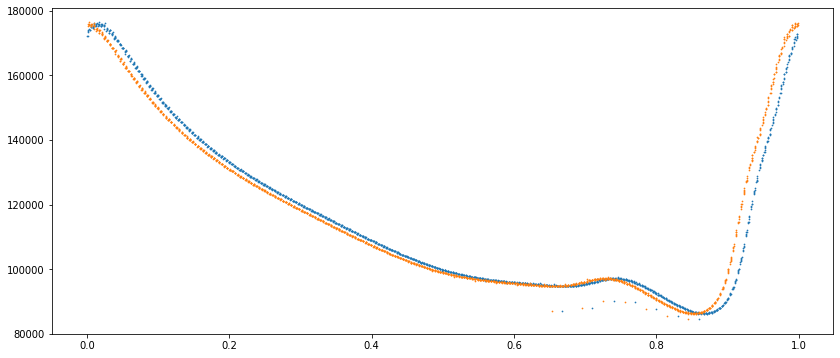

/tmp/ipykernel_2988/309669324.py:5: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
/tmp/ipykernel_2988/309669324.py:8: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % fit_periods[key])/fit_periods[key]


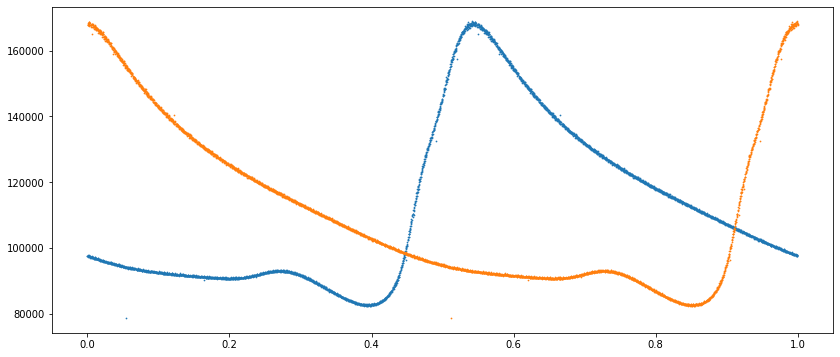

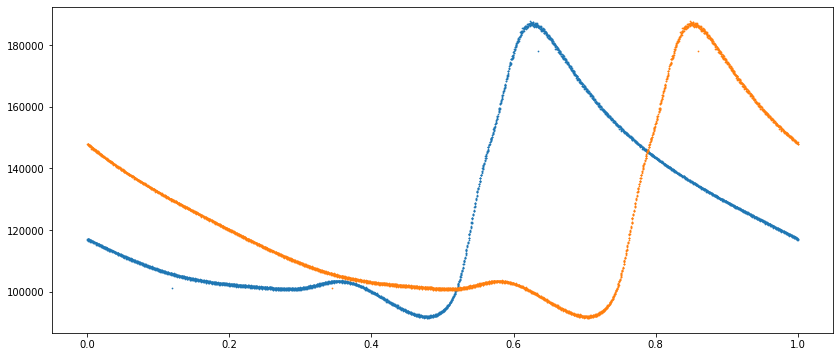

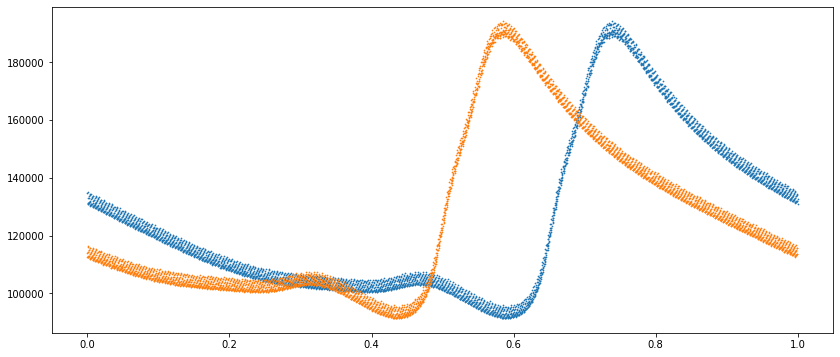

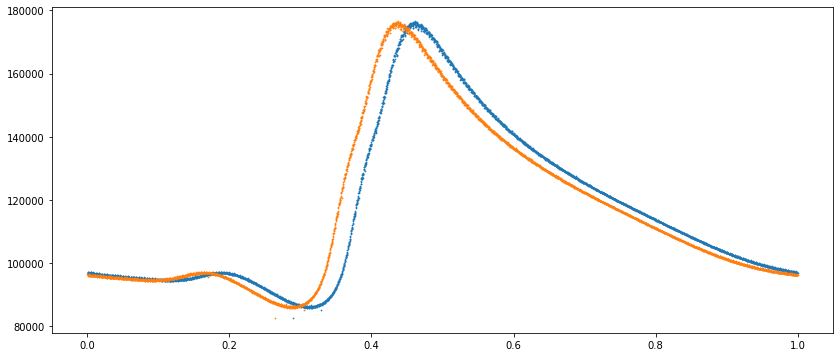

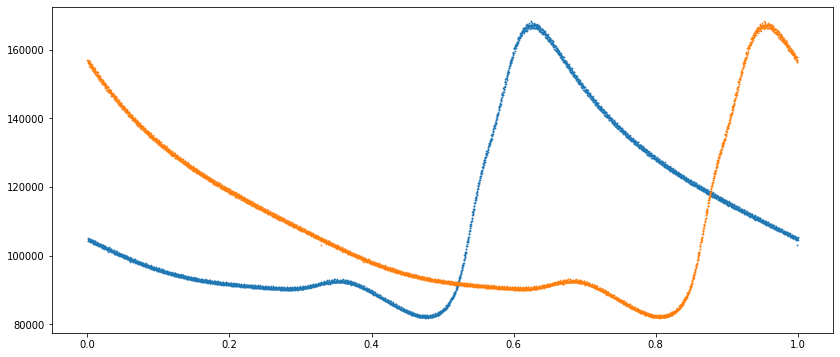

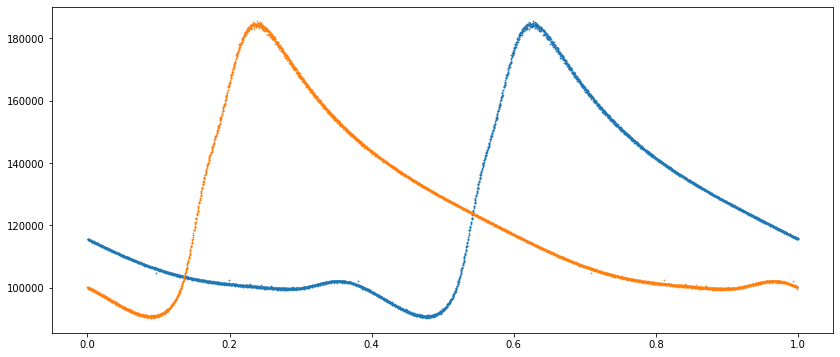

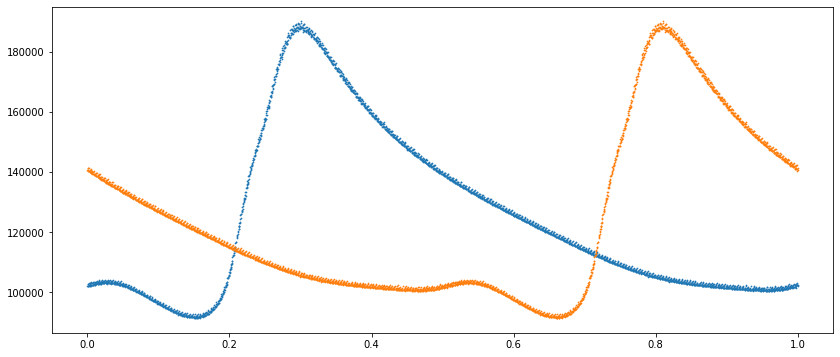

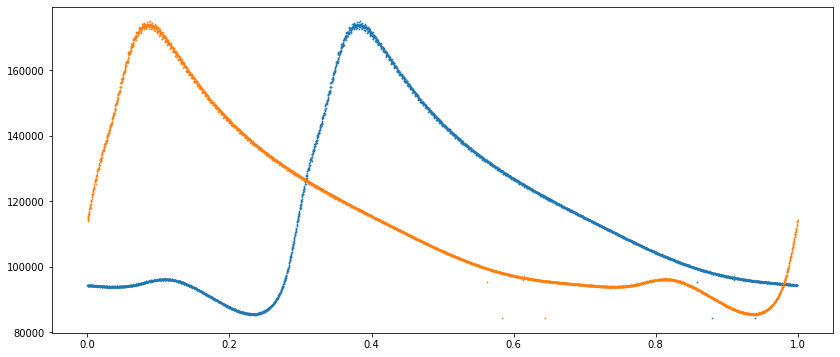

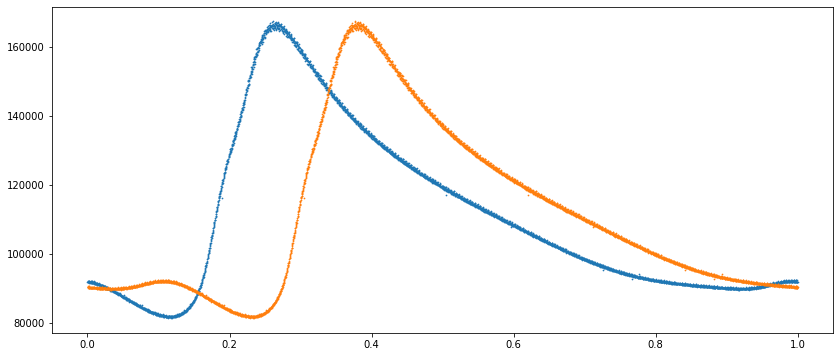

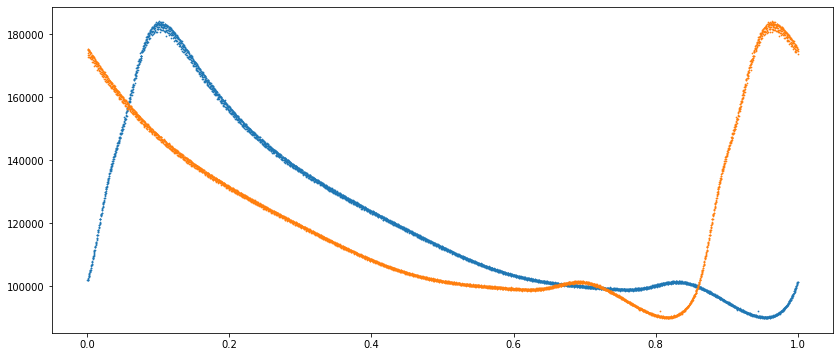

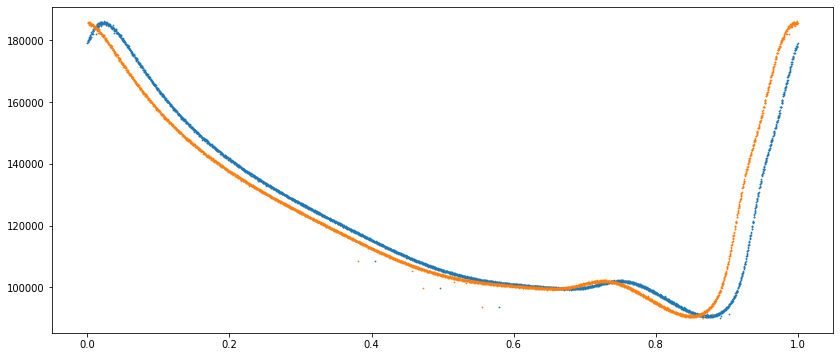

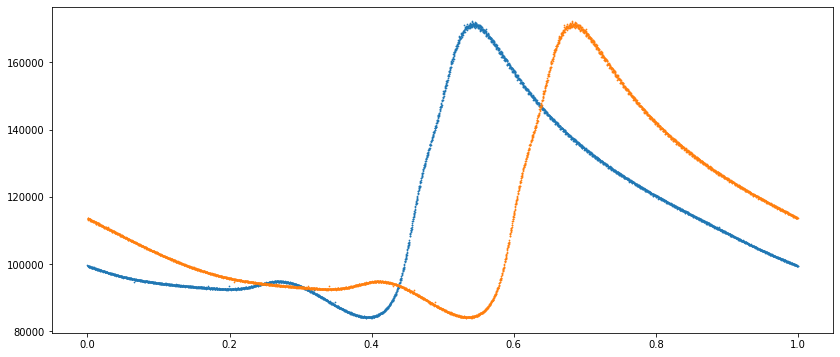

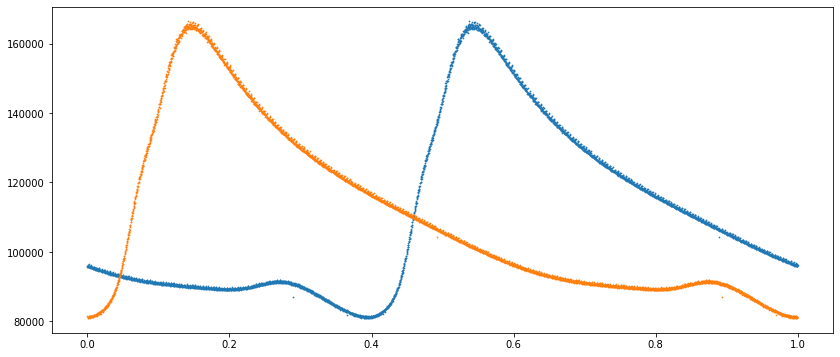

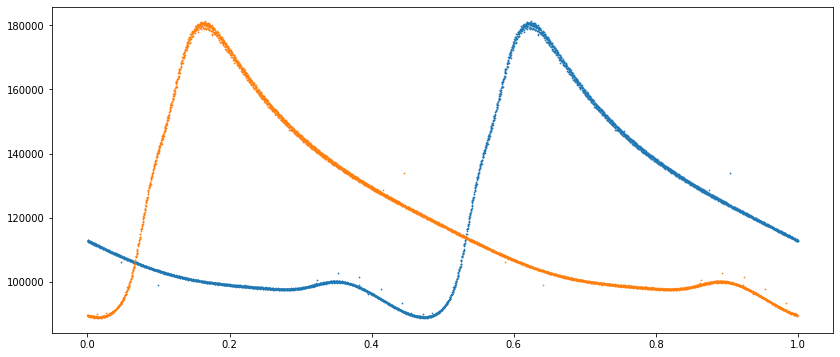

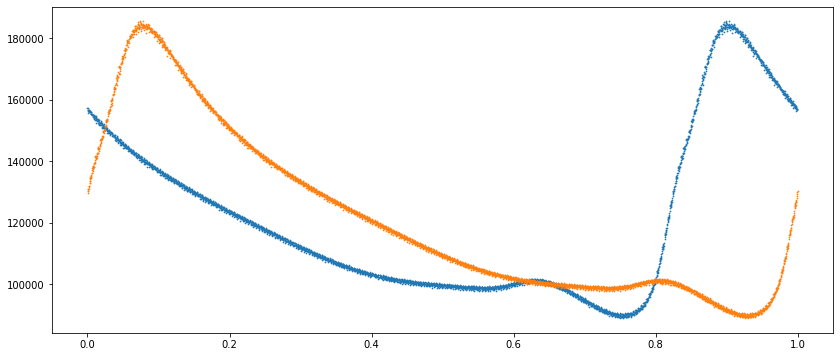

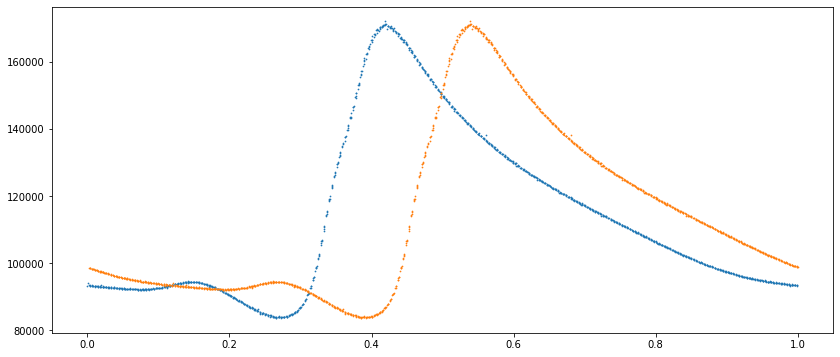

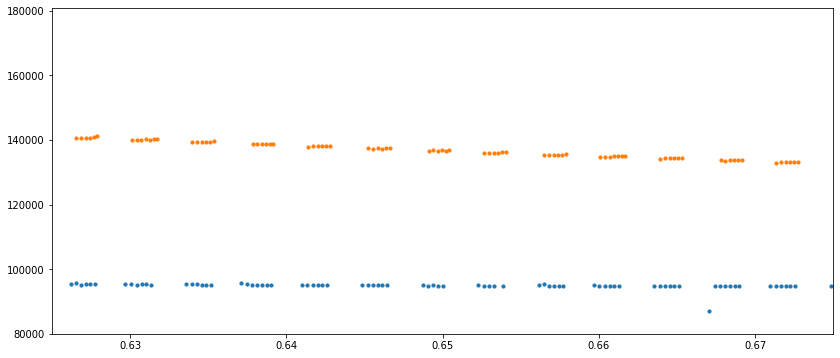

/tmp/ipykernel_2988/309669324.py:17: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
/tmp/ipykernel_2988/309669324.py:20: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % period)/period


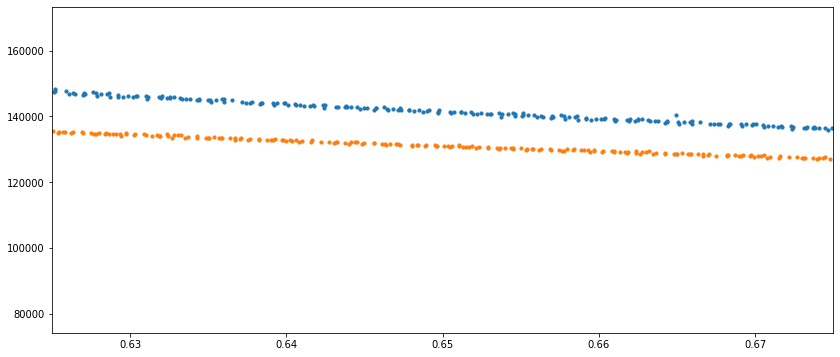

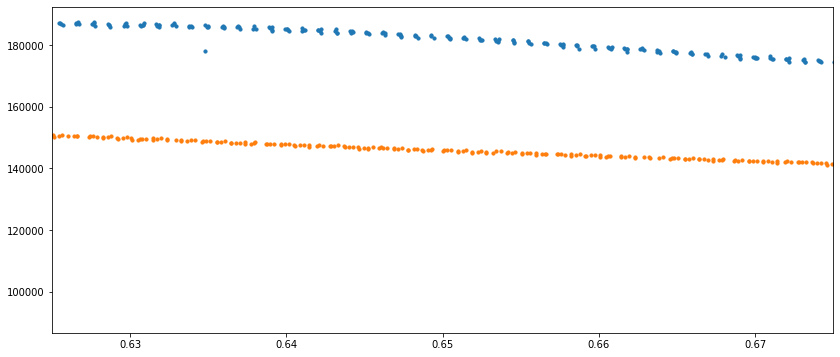

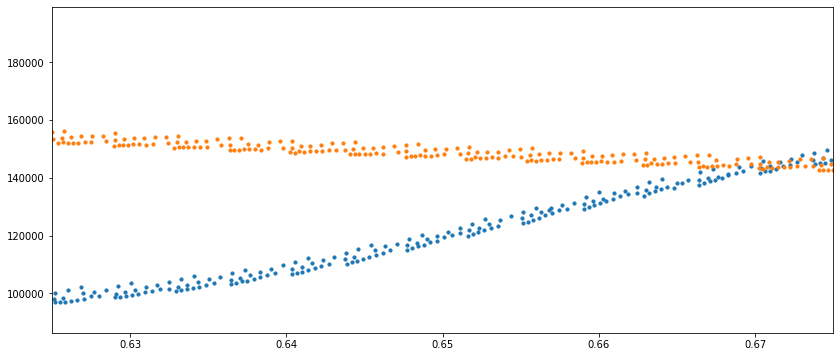

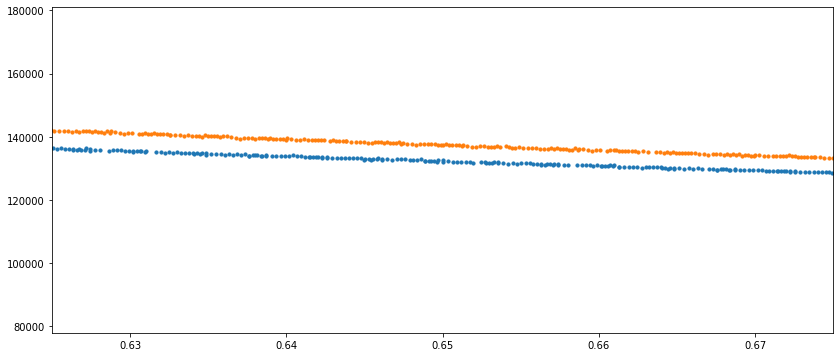

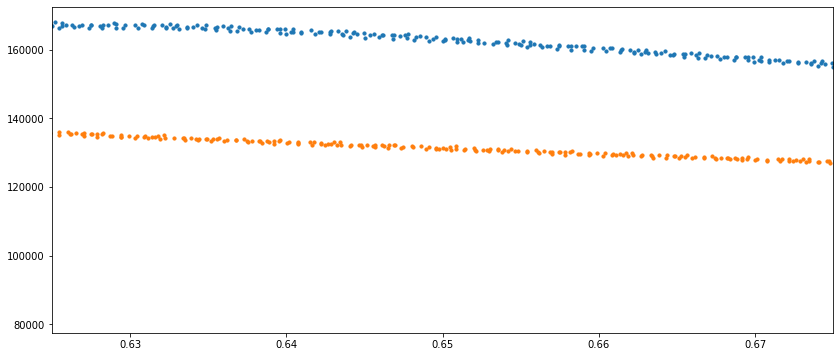

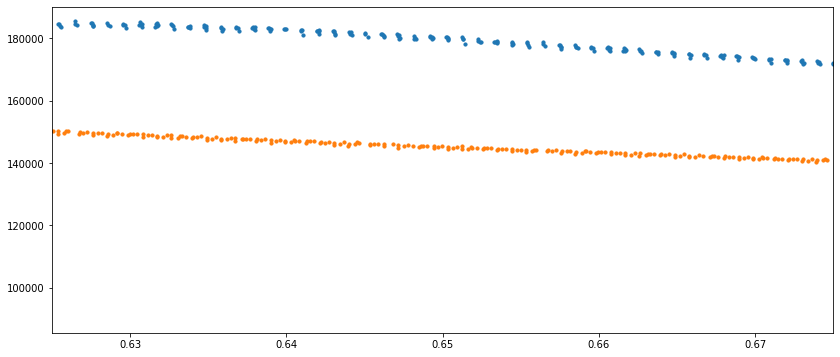

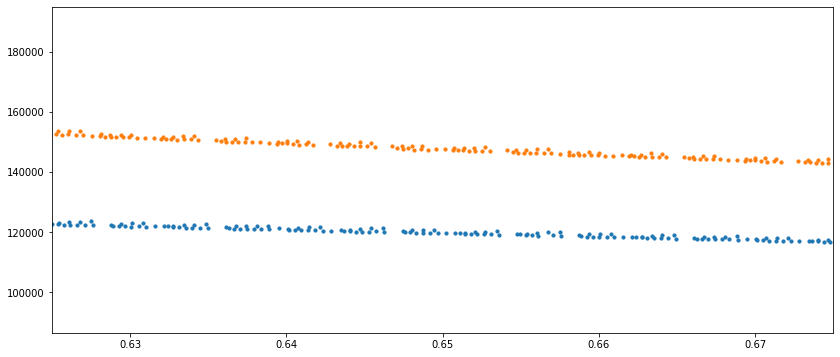

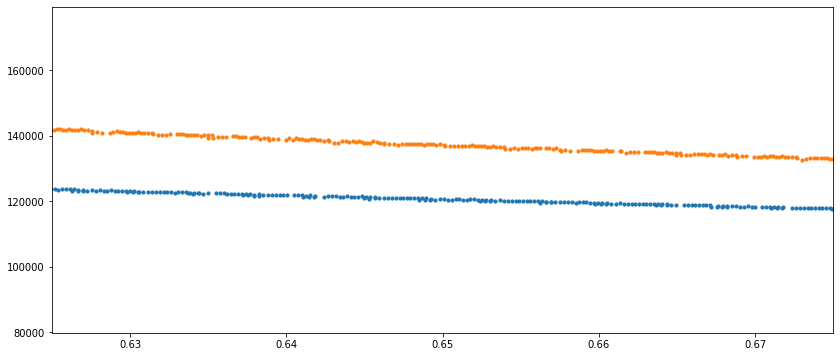

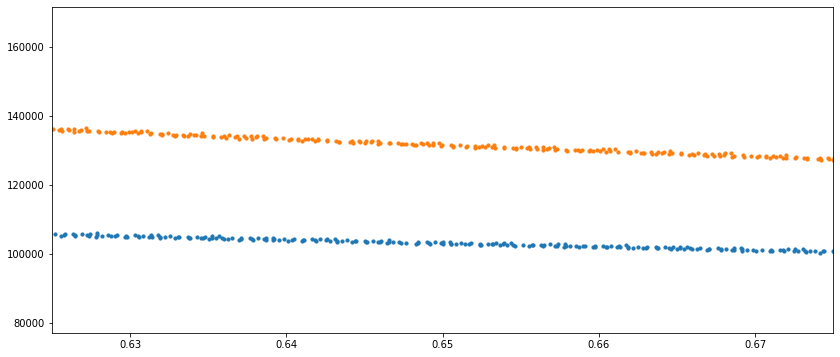

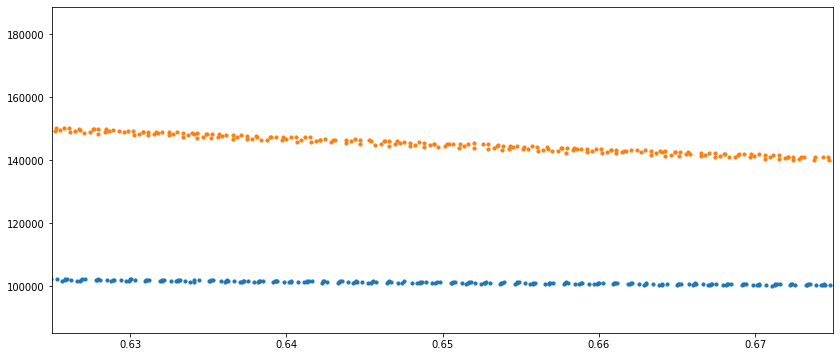

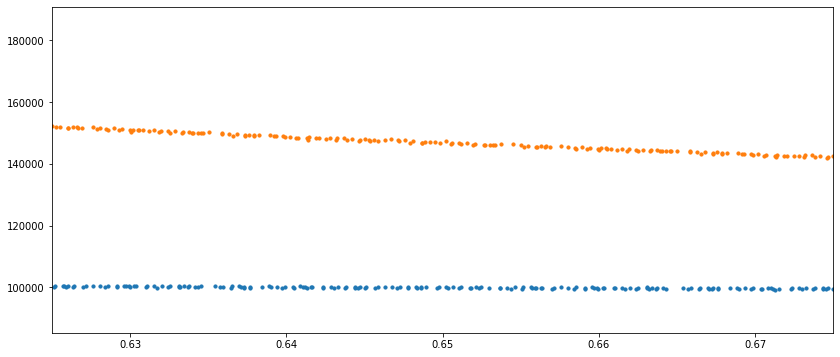

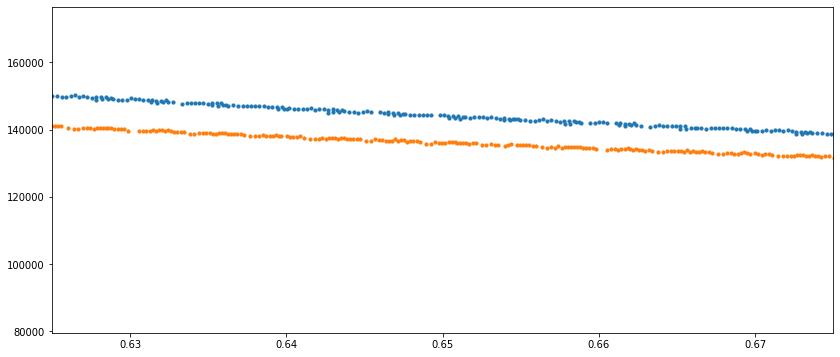

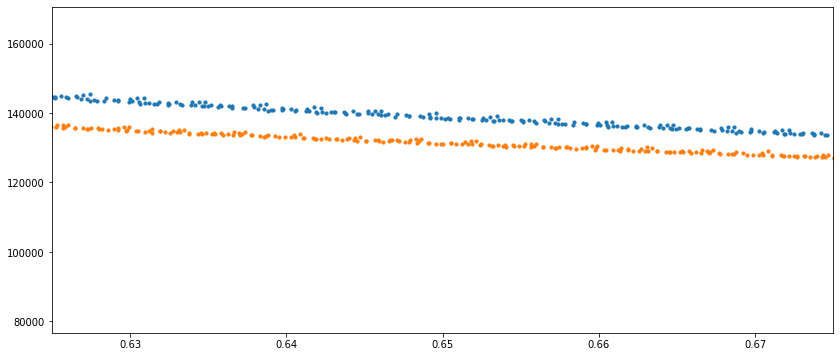

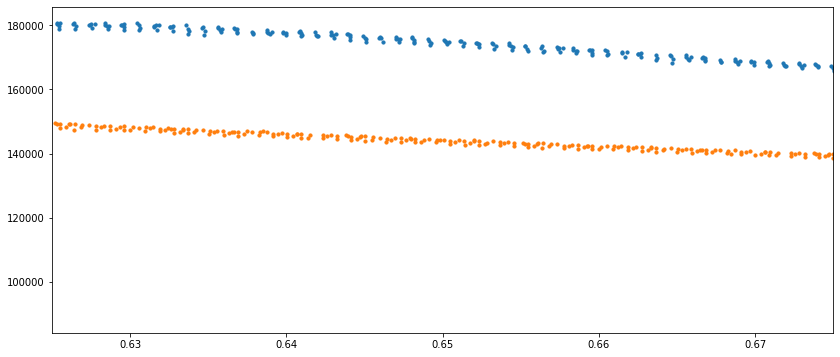

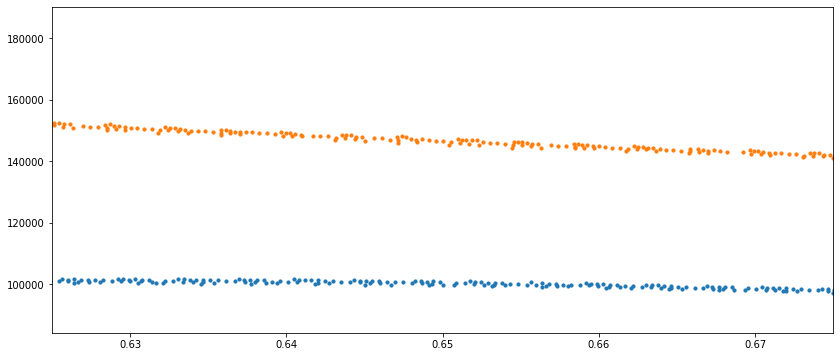

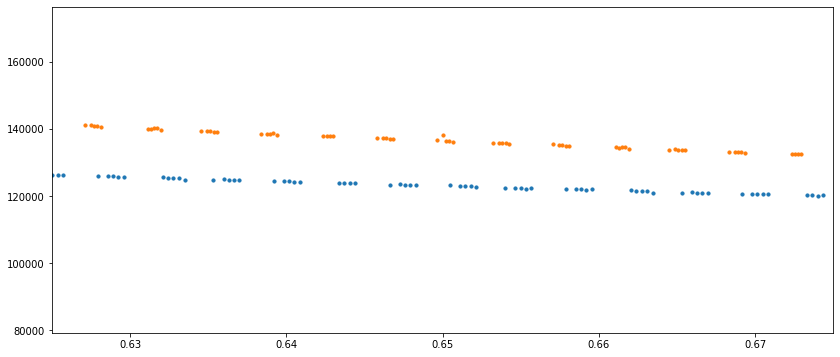

In [14]:
#print the optimized data 
for key in data.keys():
    fig = plt.figure(figsize=(14, 6))
    
    folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=0.5)
    
    folded_bjds = (data[key]['bjds'] % fit_periods[key])/fit_periods[key]
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=0.5)
    
    plt.show()
    
for key in data.keys():
    
    fig = plt.figure(figsize=(14, 6))
    
    folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10)
    
    folded_bjds = (data[key]['bjds'] % period)/period
    plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10)
    
    plt.xlim(0.625, 0.675)
    plt.show()

In [10]:
# for key in data.keys():
    
#     like1, disps1, lfs1 = likelihood(period, data[key], verbose_out=True)
#     like2, disps2, lfs2 = likelihood(best_periods[key], data[key], verbose_out=True)
    
#     fig = plt.figure(figsize=(14, 6))
    
#     folded_bjds = (data[key]['bjds'] % best_periods[key])/best_periods[key]
#     plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10, label='optimized period')
    
#     folded_bjds = (data[key]['bjds'] % period)/period
#     plt.scatter(folded_bjds, data[key]['pdcsap_fluxes'], s=10, label='given period')
#     plt.legend()
    
#     i = 0.625
#     j = int(i/0.01)
#     while i < 0.675:
#         plt.plot([i, i], [80000, 160000], ls='--', lw=1, c='k')
#         plt.text(i, 160000, disps1[int(i/0.005)], color='orange')
#         plt.text(i, 150000, disps2[int(i/0.005)], color='blue')
        
#         print(lfs1[j])

#         plt.plot([i, i+0.005], [lfs1[j].slope*i + lfs1[j].intercept, lfs1[j].slope*(i+0.005) + lfs1[j].intercept], c='r', lw=1, ls='--')
#         plt.plot([i, i+0.005], [lfs2[j].slope*i + lfs2[j].intercept, lfs2[j].slope*(i+0.005) + lfs2[j].intercept], c='cyan', lw=1, ls='--')
    
#         i += 0.005
#         j += 1

#     plt.xlim(0.625, 0.675)
#     plt.show()

dp/dt: 3.1154358192230624e-10
std dev: 1.2400093882163543e-09


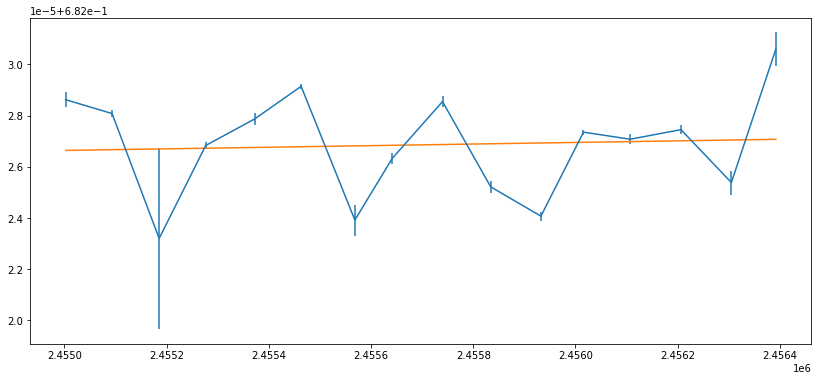

dp/dt: -1.1955278611606397e-09
uncertainty: 9.063359761344067e-10


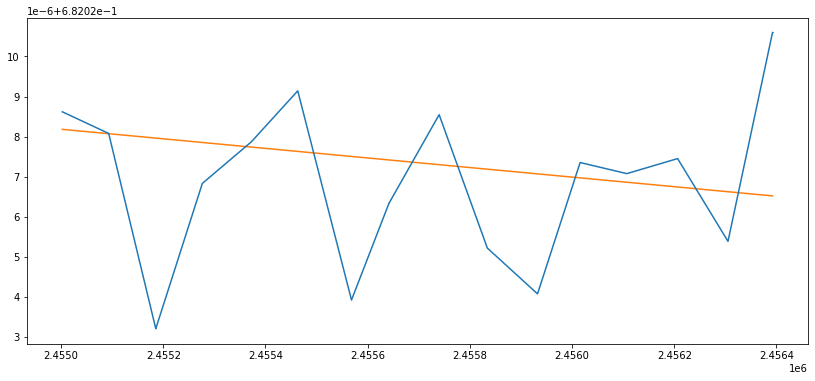

In [11]:
#plot period as a function of time

fig = plt.figure(figsize=(14, 6))
x = [data[key]['bjds'][0] for key in data.keys()][1:]
plt.errorbar(x, fit_periods[1:], yerr=np.array(variances[1:])*500)

lf = linregress(x, fit_periods[1:])
plt.plot([np.min(x), np.max(x)], [lf[0]*np.min(x) + lf[1], lf[0]*np.max(x) + lf[1]])
print('dp/dt:', lf.slope)
print('std dev:', lf.stderr)
print('==========================')
plt.show()

def func(x, m, b):
    return m*x + b

cf = curve_fit(func, x, fit_periods[1:], sigma=variances[1:])
perr = np.sqrt(np.diag(cf[1]))
print('dp/dt:', cf[0][0])
print('uncertainty:', perr[0])

fig = plt.figure(figsize=(14, 6))
plt.errorbar(x, fit_periods[1:], yerr=variances[1:])
plt.plot([np.min(x), np.max(x)], [cf[0][0]*np.min(x) + cf[0][1], cf[0][0]*np.max(x) + cf[0][1]])
plt.show()

In [12]:
#fit a line to it (dp/dt)

#compute dispersion of those points/quality of linear fit